# Sales pred simple ranking  
## ***Experience*** **52**:  
### -aggregated sales in different stores  
### -single-general learner  
### -without markdowns?  

## Contributions:
### - wide range of methods 
### - department based error(p_err and n_err) calculation
### - waited error ranking (check EXPLAIN method in exact folder)

In [2]:
# 0-importing necessary packages

import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from datetime import datetime
import statsmodels.api as sm
from pycaret.regression import *
import xgboost as xgb
import catboost as ctb
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf
import shap
print('Importing libraries: Done')

Importing libraries: Done


In [3]:
# 1-Inputs operation


# 1-1 Checking inputs
print("Folder's files : ",os.listdir('inputs'), '\n')

# 1-2 Reading input CSV files and assigning a name to each one of them 
dataset = pd.read_csv("inputs/train.csv", names=['Store','Dept','Date','weeklySales','isHoliday'],sep=',', header=0)
features = pd.read_csv("inputs/features.csv",sep=',', header=0,names=['Store','Date','Temperature','Fuel_Price','MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5','CPI','Unemployment','IsHoliday']).drop(columns=['IsHoliday'])
stores = pd.read_csv("inputs/stores.csv", names=['Store','Type','Size'],sep=',', header=0)

# 1-3 Creating needed directories
os.makedirs('temp_test', exist_ok=True)
os.makedirs('input_analysis', exist_ok=True)
os.makedirs('pred_output', exist_ok=True)
os.makedirs('pred_output/exp51', exist_ok=True)
os.makedirs('output_analysis', exist_ok=True)
os.makedirs('output_analysis/exp52', exist_ok=True)

# 1-4 Flating data(merging different data bases into one table)
dataset = dataset.merge(stores, how='left').merge(features, how='left')  

# 1-5 Decreasing unnecessary memory usage 
dataset['Store'] = dataset['Store'].astype('int16')
dataset['Dept'] = dataset['Dept'].astype('int16')
dataset['weeklySales'] = dataset['weeklySales'].astype('float64')

# 1-6 Printing flatted dataset
print('─' * 100,'\n Original dataset sample: \n', dataset)

Folder's files :  ['features.csv', 'inputs.rar', 'inputs.zip', 'stores.csv', 'test.csv', 'train.csv'] 

──────────────────────────────────────────────────────────────────────────────────────────────────── 
 Original dataset sample: 
         Store  Dept        Date  weeklySales  isHoliday Type    Size  \
0           1     1  2010-02-05     24924.50      False    A  151315   
1           1     1  2010-02-12     46039.49       True    A  151315   
2           1     1  2010-02-19     41595.55      False    A  151315   
3           1     1  2010-02-26     19403.54      False    A  151315   
4           1     1  2010-03-05     21827.90      False    A  151315   
...       ...   ...         ...          ...        ...  ...     ...   
421565     45    98  2012-09-28       508.37      False    B  118221   
421566     45    98  2012-10-05       628.10      False    B  118221   
421567     45    98  2012-10-12      1061.02      False    B  118221   
421568     45    98  2012-10-19       760.01  

In [4]:
# 2-Data extraction

# 2-1 Deriving a sub-dataset from main dataset 
dataset_sub1 = dataset[['Date','Dept','Store', 'Type','MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5','isHoliday','weeklySales']]
dataset_sub1 = dataset_sub1.sort_index(axis=0)

# 2-2 getting list of unique departments' values
dept_list = dataset_sub1['Dept'].unique()
dept_list.sort()

# 2-3 getting list of unique stores' values
store_list = dataset_sub1['Store'].unique()
store_list.sort()

# 2-4 getting list of unique dates
date_list = dataset_sub1['Date'].unique()
date_list.sort()

# 2-5 Check printing 
print('Dataset_sub1: \n',dataset_sub1)
print('─' * 100,'\n List of Departments: \n',dept_list,'\n')
print('─' * 100,'\n List of Stores: \n',store_list,'\n')
print('─' * 100,'\n List of Dates: \n',date_list)

# Deriving a sub-dataset from main dataset which considers 9 more important features
#datasub_sub3 = dataset[['Date','Store','Dept','weeklySales','MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5']]
#dataset_sub3 = dataset_sub3.sort_index(axis=0)
#Print('\n\n', dataset_sub3.tail(5))

Dataset_sub1: 
               Date  Dept  Store Type  MarkDown1  MarkDown2  MarkDown3  \
0       2010-02-05     1      1    A        NaN        NaN        NaN   
1       2010-02-12     1      1    A        NaN        NaN        NaN   
2       2010-02-19     1      1    A        NaN        NaN        NaN   
3       2010-02-26     1      1    A        NaN        NaN        NaN   
4       2010-03-05     1      1    A        NaN        NaN        NaN   
...            ...   ...    ...  ...        ...        ...        ...   
421565  2012-09-28    98     45    B    4556.61      20.64       1.50   
421566  2012-10-05    98     45    B    5046.74        NaN      18.82   
421567  2012-10-12    98     45    B    1956.28        NaN       7.89   
421568  2012-10-19    98     45    B    2004.02        NaN       3.18   
421569  2012-10-26    98     45    B    4018.91      58.08     100.00   

        MarkDown4  MarkDown5  isHoliday  weeklySales  
0             NaN        NaN      False     24924.50

In [ ]:
# 3-Data cleaning

# 3-1 this function identifies departmets in different stores that have incomplete data or have below 0 sales values. the function then makes a dictionary of outliers(Test:OK)
def outlier_identifier(df, border_value, store_list, dept_list):
    data_map = pd.DataFrame(columns=['store', 'dept', 'number_of_entries', 'target_false_count', 'outlier_flag'])
    for i in store_list:
        for j in dept_list:
            number_of_entries = df[(df.Store == i) & (df.Dept == j)].Date.count()
            number_of_entries = number_of_entries.astype('int16')
            target_false_count = df[(df.weeklySales <= border_value) & (df.Store == 
                                                                        i) & (df.Dept == j)].weeklySales.count()
            target_false_count = target_false_count.astype('int16')
            if (number_of_entries == 143) & (target_false_count == 0):
                outlier_flag = 0
            else:
                outlier_flag = 1
            new_row = {'store': i, 'dept': j, 'number_of_entries': number_of_entries, 'target_false_count': target_false_count, 'outlier_flag': outlier_flag}
            data_map.loc[len(data_map)] = new_row
    return data_map

# 3-2 this function removes departmets in different stores that have incomplete data or have below 0 sales values.(Test:OK)
def outlier_remover(df, removal_map):
    for i in removal_map.index:
        a = removal_map.iloc[[i]].store
        a.reset_index(drop=True, inplace=True)
        b = removal_map.iloc[[i]].dept
        b.reset_index(drop=True, inplace=True)
        print('Store:', a[0], 'Department:', b[0],' Removed as outlier!','\n')
        index = df[(df.Store == a[0]) & (df.Dept == b[0])].index
        for j in index:
            df.drop(j , inplace=True)
    return df

# 3-3 Executing outlier identifier and save it as a mapping dataframe to know which store and department mix should be droped(Test:OK)
data_map = outlier_identifier(dataset_sub1, 0, store_list, dept_list)
removal_map = data_map[['store','dept','outlier_flag']]
removal_map = removal_map[removal_map.outlier_flag == 1]
removal_map.reset_index(drop=True, inplace=True)

# 3-4 Printing percentage of outlier data in compare with whole data
print('outlier percentage:', data_map[data_map.outlier_flag == 1].store.count() / 3645 ,'─' * 100, '\n')

# 3-5 Executing outlier remover
dataset_sub2 = outlier_remover(dataset_sub1, removal_map)

# 3-6 Filling empty numeric values with 0  &  reseting index
dataset_sub2 = dataset_sub2.fillna(0)
dataset_sub2 = dataset_sub2.reset_index(drop=True)

# 3-7 Outlier removing process is considerably time consuming, therefore we save it and recall cleaned data later.
dataset_sub2.to_csv('temp_test/dataset_sub2_exp51.csv') 

# 3-8 Printing the result of data cleaning process
print('─' * 100, '\n Cleaned Dataset: \n', dataset_sub2)    

──────────────────────────────────────────────────────────────────────────────────────────────────── 

outlier percentage: 0.2792866941015089 ──────────────────────────────────────────────────────────────────────────────────────────────────── 

Store: 1 Department: 6  Removed as outlier! 

Store: 1 Department: 18  Removed as outlier! 

Store: 1 Department: 39  Removed as outlier! 

Store: 1 Department: 43  Removed as outlier! 

Store: 1 Department: 45  Removed as outlier! 

Store: 1 Department: 47  Removed as outlier! 

Store: 1 Department: 48  Removed as outlier! 

Store: 1 Department: 50  Removed as outlier! 

Store: 1 Department: 51  Removed as outlier! 



In [5]:
# 4-Reading cleaned dataset and updating some lists after cleaning

# 4-1 Reading saved clean data from memory
dataset_sub2 = pd.read_csv("temp_test/dataset_sub2_exp51.csv", names=['Date','Dept','Store', 'Type','MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5','isHoliday','weeklySales'],sep=',', header=0)
dataset_sub3 = dataset_sub2[['Date','Dept','weeklySales']]

# 4-2 Updating list of unique departments' values
dept_list = dataset_sub2['Dept'].unique()
dept_list.sort()

# 4-3 Updating list of unique stores' values
store_list = dataset_sub2['Store'].unique()
store_list.sort()

# 4-4 Updating list of unique dates
date_list = dataset_sub2['Date'].unique()
date_list.sort()

print('List of Departments:',dept_list,'\n')
print('─' * 100, '\n List of Stores: \n',store_list,'\n')
print('─' * 100, '\n List of Dates: \n',date_list)


List of Departments: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 16 17 19 20 21 22 23 24 25 26
 27 28 29 30 31 32 33 34 35 36 37 38 40 41 42 44 46 48 49 50 52 55 56 58
 59 60 65 67 71 72 74 79 80 81 82 83 85 87 90 91 92 93 94 95 96 97 98] 

──────────────────────────────────────────────────────────────────────────────────────────────────── 
 List of Stores: 
 [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45] 

──────────────────────────────────────────────────────────────────────────────────────────────────── 
 List of Dates: 
 ['2010-02-05' '2010-02-12' '2010-02-19' '2010-02-26' '2010-03-05'
 '2010-03-12' '2010-03-19' '2010-03-26' '2010-04-02' '2010-04-09'
 '2010-04-16' '2010-04-23' '2010-04-30' '2010-05-07' '2010-05-14'
 '2010-05-21' '2010-05-28' '2010-06-04' '2010-06-11' '2010-06-18'
 '2010-06-25' '2010-07-02' '2010-07-09' '2010-07-16' '2010-07-23'
 '2010-07-30' '2010-08-06' '2010-08-13' '2010-08-

In [8]:
# 5-Defining experiment process, models, and methods

# 5-1 This function aggregates stores weekly sales(Test:OK)
def aggregator(df):
    aggr = df.groupby(['Date','Dept'], as_index=False).sum()
    return aggr

# 5-2 This function gets a ataframe input and gives a dataframe output with transformed features. (Test:OK) 
# also the function reduces data types to minimum ram needed
def create_features(df):
    features = df
    features['Date'] = pd.to_datetime(df['Date'])
    features['dayofweek'] = df['Date'].dt.dayofweek
    features['quarter'] = df['Date'].dt.quarter
    features['month'] = df['Date'].dt.month
    features['year'] = df['Date'].dt.year
    features['dayofyear'] = df['Date'].dt.dayofyear
    features['dayofmonth'] = df['Date'].dt.day
    features['weekofyear'] = df['Date'].dt.weekofyear

    cols_int16 = ['dayofweek','quarter','month','year','dayofyear','dayofmonth','weekofyear', 'Dept']
    for col in cols_int16:
        features['{}'.format(col)] = df['{}'.format(col)].astype('int16')

    cols_float32 = ['weeklySales']
    for col in cols_float32:
        features['{}'.format(col)] = df['{}'.format(col)].astype('float32')
        
    X = features[['Date','dayofweek','quarter','month','year','dayofyear','dayofmonth','weekofyear', 'Dept', 'weeklySales']]
    X.index = features.index
    print('\n >>features: \n',X)
    return X

# 5-3 This function derives train and test datasets from a tmie-series database due to an input date(Test:OK)
def split_data(df, split_date):
    return df[df.Date < split_date].copy(), \
            df[df.Date >= split_date].copy()
    
# 5-4 This function plots test and train values of target in time (Test:NA)
def plt_test_train(df_train, df_test):
    plt.figure(figsize = (20,10))
    plt.xlabel('date')
    plt.ylabel('weekly sales')
    plt.plot(df_train.index, df_train['weeklySales'],label = 'train')
    plt.plot(df_test.index, df_test['weeklySales'], label ='test')
    plt.legend()
    plt.show()
    msg = 'PLT Done ! \n'
    return msg

# 5-5 This function creates, tunes, plots, finalizes, predicts, and evaluates all models in mdls list for a set of data (Test:NA)
def create_models(mdls, test, result_log):
    for mdl in mdls:
        mdll = create_model('{}'.format(mdl))
        print('\n \n >>mdll = create_model(mdl) for Model:{} IS  DONE! \n \n'.format(mdl))
        tuned_mdl = tune_model(mdll, n_iter = 10)
        print('\n \n >>tuned_mdl = tune_model(mdll) for Model:{} IS  DONE! \n \n'.format(mdl))
        
        #plot_model(mdll)
        #print('\n \n >>plot_model(mdll) for Model:{} IS  DONE! \n \n'.format(mdl))
        #plot_model(mdll, plot = 'error')
        #print('\n \n >>plot_model(mdll, plot = error) for Model:{} IS  DONE! \n \n'.format(mdl))
        #plot_model(tuned_mdl, plot = 'feature')
        #print('\n \n >>plot_model(tuned_mdl, plot = feature) for Model:{} IS  DONE! \n \n'.format(mdl))
        
        predict_model(tuned_mdl)
        print('\n \n >>predict_model(tuned_mdl) for Model:{} IS  DONE! \n \n'.format(mdl))
        
        final_mdl = finalize_model(tuned_mdl)
        print('\n \n >>final_mdl = finalize_model(tuned_mdl) for Model:{} IS  DONE! \n \n'.format(mdl))

        plt(tuned_mdl)
        
        print(final_mdl)
        print('\n \n >>print(final_mdl) for Model:{} IS  DONE! \n \n'.format(mdl))
        #evaluate_model(final_mdl)
        #print('\n \n >>evaluate_model(final_mdl) for Model:{} IS  DONE! \n \n'.format(mdl))
        
        predict_model(final_mdl)
        print('\n \n >>predict_model(final_mdl) for Model:{} IS  DONE! \n \n'.format(mdl))
        
        pred_mdl = predict_model(final_mdl, data=test)
        pred_mdl.to_csv('pred_output/exp51/{}_pred.csv'.format(mdl))
        print('\n \n >>pred_mdl = predict_model(final_mdl, data=test) for Model:{} IS  DONE! \n \n'.format(mdl))

        result_log = result_logger(mdl, pred_mdl, result_log)


        
        #result_log[mdl] = pred_mdl.prediction_label
        #result_log['{}_ape'.format(mdl)] = ((result_log.actual - result_log[mdl]) / result_log.actual).abs() 
        #result_log['{}_pe'.format(mdl)] = ((result_log.actual - result_log[mdl]) / result_log.actual) 
        #result_log['{}_pos_pe'.format(mdl)] = result_log[(result_log['{}_pe'.format(mdl)] >= 0)]['{}_pe'.format(mdl)]
        #result_log['{}_neg_pe'.format(mdl)] = result_log[(result_log['{}_pe'.format(mdl)] < 0)]['{}_pe'.format(mdl)]
        #result_log['{}_err_p2'.format(mdl)] = ((result_log.actual - result_log[mdl])^2) 
        
        #pos_pe_mean = result_log['{}_pos_pe'.format(mdl)].mean()
        #max_pos_pe = result_log['{}_pos_pe'.format(mdl)].max()
        #neg_pe_mean = result_log['{}_neg_pe'.format(mdl)].mean()
        #max_neg_pe = result_log['{}_neg_pe'.format(mdl)].min()
        #mape = result_log['{}_ape'.format(mdl)].mean()
        #err_sum = result_log['{}_err_p2'.format(mdl)].sum()
        #err_count = result_log['{}_err_p2'.format(mdl)].count()
        #var = (err_sum / (err_count - 1))
        #sd = ((err_sum / (err_count - 1))^0.5)

        #result_log_aggr.at[i, '{}_pos_pe_sum'.format(mdl)] = pos_pe_sum
        #result_log_aggr.at[i, '{}_max_pos_pe'.format(mdl)] = max_pos_pe
        #result_log_aggr.at[i, '{}_neg_pe_sum'.format(mdl)] = neg_pe_sum
        #result_log_aggr.at[i, '{}_max_neg_pe'.format(mdl)] = max_neg_pe
        #result_log_aggr.at[i, '{}_mape'.format(mdl)] = mape
        
        #dept_mape_list.append(result_log['{}_ape'.format(mdl)].mean())
        #result_log_aggr = dept_mape_list.add(mape)
        print('\n \n >> Prediction of Model:{}  IS  DONE!'.format(mdl))
    return result_log   
    #pass


# 5-6 This function sets up machine-learning process configurations(Test:NA)
def mlsetup(train, test):
    reg = setup(data = train,
            test_data = test,
            target = 'weeklySales',
            categorical_features = ['Dept','dayofweek','quarter','month','year','dayofyear','dayofmonth','weekofyear'],
            #numeric_features = ['Date', 'Dept','Store','dayofweek','quarter','month','year','dayofyear','dayofmonth','weekofyear','MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5'],
            #preprocess = False,
            imputation_type = None, #We dont want to impute missing values because they are alreay imputed.
            #numeric_imputation = 'mean',
            #polynomial_features = False, #it means we do not want to take existing features and raise them to a power to capture non-linear relationships between the feature and the target variable.
            #transformation = False,
            #normalize = False,
            #normalize_method = 'zscore',
            #transform_target = False,
            #remove_multicollinearity = False,
            #multicollinearity_threshold = 0.95,
            remove_outliers = False,
            #outliers_method = 'ee' #options are 'ee', 'lof', 'iforest',
            #outliers_threshhold = 0.05,
            #feature_selection = False,
            #feature_selection_method = 'sequential',
            #feature_selection_estimator = 'lightgbm',
            #n_features_to_select = 0.2,
            #use_gpu = True,
            #profile = True,
            #fold_strategy = 'kfold', #other options are 'kfold', 'groupkfold', 'timeseries'
            #fold = 10,  
            #fold_groups = 'dept',
            #data_split_shuffle = False,
            #fold_shuffle = True,
           )
    print('\n \n >>ML setup  IS  DONE! \n \n')
    #best = compare_models(sort = 'MAPE', n_select = 1)
    #best2 = compare_models(sort = 'MAPE', n_select = 2)
    best3 = compare_models(sort = 'MAPE', n_select = 3)
    #best4 = compare_models(sort = 'MAPE', n_select = 4)
    #best5 = compare_models(sort = 'MAPE', n_select = 5)
    #print('\n \n >>best = compare_models IS  DONE! \n \n')
    #evaluate_model(best)
    #print('\n \n >>evaluate_model(best) IS  DONE! \n \n')
    return best3
    #pass


# 5-7 This function executes each step of the whole experiment process one by one.(Test:NA)
#Experiment51:
def experiment52(df, split_date, mdls):
    y = aggregator(df)
    z = create_features(y)
    train, test = split_data(z, split_date)
    train2 = train.drop(columns=['Date'])
    test2 = test.drop(columns=['Date'])
    print('>create features and split_data func is Done! \n')
    
    mlsetup(train2, test2)
    print('\n >mlsetup func is Done! \n')

    result_log = result_log_init(test)
    result_log = create_models(mdls, test, result_log)
    result_log.to_csv('output_analysis/exp52/result_log.csv')

    output_anal = output_analyzer(result_log, mdls)
    output_anal.to_csv('output_analysis/exp52/output_anal.csv')
    
    print('\n >create_models func is Done! \n')
        
    #result_log_aggr_exp1.to_csv('output_analysis/exp1/result_log_aggr_exp1.csv')
    process_end_msg = '>>>>>>>>>>> Experience 52 is DONE! <<<<<<<<<<<<'
    print(process_end_msg)
    pass


# 5-8 This function
def result_logger(mdl, pred, result_log):  
    result_log[mdl] = pred.prediction_label
    result_log['{}_ape'.format(mdl)] = ((result_log.actual - result_log[mdl]) / result_log.actual).abs() 
    result_log['{}_pe'.format(mdl)] = ((result_log.actual - result_log[mdl]) / result_log.actual) 
    result_log['{}_pos_pe'.format(mdl)] = result_log[(result_log['{}_pe'.format(mdl)] >= 0)]['{}_pe'.format(mdl)]
    result_log['{}_neg_pe'.format(mdl)] = result_log[(result_log['{}_pe'.format(mdl)] < 0)]['{}_pe'.format(mdl)]
    result_log['{}_err_p2'.format(mdl)] = ((result_log.actual - result_log[mdl]) ** 2)
    return result_log


# 5-8 This function
def result_log_init(test_df):  
    #initiating result log 
    result_log = pd.DataFrame()
    result_log.index = test_df.index
    result_log['Date'] = test_df['Date']
    result_log['Dept'] = test_df['Dept']
    result_log['actual'] = test_df['weeklySales'] 
    return result_log


# 5-9 This function
def output_analyzer(result_log, mdls):
    output_anal = pd.DataFrame()
    output_anal.index = mdls

    for mdl in mdls:
        pos_pe_mean = result_log['{}_pos_pe'.format(mdl)].mean()
        max_pos_pe = result_log['{}_pos_pe'.format(mdl)].max()
        neg_pe_mean = result_log['{}_neg_pe'.format(mdl)].mean()
        max_neg_pe = result_log['{}_neg_pe'.format(mdl)].min()
        mape = result_log['{}_ape'.format(mdl)].mean()
        err_sum = result_log['{}_err_p2'.format(mdl)].sum()
        err_count = result_log['{}_err_p2'.format(mdl)].count()
        var = (err_sum / (err_count - 1))
        sd = ((err_sum / (err_count - 1))**0.5)

        output_anal.at[mdl, 'pos_pe_mean'] = pos_pe_mean
        output_anal.at[mdl, 'max_pos_pe'] = max_pos_pe
        output_anal.at[mdl, 'neg_pe_mean'] = neg_pe_mean
        output_anal.at[mdl, 'max_neg_pe'] = max_neg_pe
        output_anal.at[mdl, 'mape'] = mape
        output_anal.at[mdl, 'var'] = var
        output_anal.at[mdl, 'sd'] = sd
    return output_anal


    #output_anal_dept_best = pd.DataFrame()
    #output_anal.index = dept_list

# 5-10 This function
def plt(mdl):
    plot_model(mdl)
    plot_model(mdl, plot = 'error')
    plot_model(mdl, plot='feature')
    plot_model(mdl, plot = 'learning')
    plot_model(mdl, plot = 'manifold')
    plot_model(mdl, plot = 'feature_all')
    plot_model(mdl, plot = 'parameter')
    #plot_model(final_blend, plot = 'error')

    #interpret_model(mdl)
    #interpret_model(mdl, plot = 'correlation')
    #interpret_model(mdl, plot = 'reason', observation = 12)
        
    #plot_model(mdll)
    #print('\n \n >>plot_model(mdll) for Model:{} IS  DONE! \n \n'.format(mdl))
    #plot_model(mdll, plot = 'error')
    #print('\n \n >>plot_model(mdll, plot = error) for Model:{} IS  DONE! \n \n'.format(mdl))
    #plot_model(tuned_mdl, plot = 'feature')
    print('\n \n >>plotting is  DONE! \n \n')
    pass

# 5-10 This function
#def mix_methods():
#    blend = blend_models(estimator_list = [tuned_catboost, tuned_br, tuned_rf])
#    pred = predict_model(blend)
#    final_blend = finalize_model(blend)

#bagged_dt = ensemble_model(dt, n_estimators=50)
#boosted_dt = ensemble_model(dt, method = 'Boosting')
#blender = blend_models()
#stacker = stack_models(estimator_list = compare_models(n_select=5, fold = 5, whitelist = models(type='ensemble').index.tolist()))



 >>features: 
             Date  dayofweek  quarter  month  year  dayofyear  dayofmonth  \
0     2010-02-05          4        1      2  2010         36           5   
1     2010-02-05          4        1      2  2010         36           5   
2     2010-02-05          4        1      2  2010         36           5   
3     2010-02-05          4        1      2  2010         36           5   
4     2010-02-05          4        1      2  2010         36           5   
...          ...        ...      ...    ...   ...        ...         ...   
10148 2012-10-26          4        4     10  2012        300          26   
10149 2012-10-26          4        4     10  2012        300          26   
10150 2012-10-26          4        4     10  2012        300          26   
10151 2012-10-26          4        4     10  2012        300          26   
10152 2012-10-26          4        4     10  2012        300          26   

       weekofyear  Dept   weeklySales  
0               5     1  8.8183


 
 >>ML setup  IS  DONE! 
 




 >mlsetup func is Done! 




 
 >>mdll = create_model(mdl) for Model:xgboost IS  DONE! 
 



Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).

 
 >>tuned_mdl = tune_model(mdll) for Model:xgboost IS  DONE! 
 




 
 >>predict_model(tuned_mdl) for Model:xgboost IS  DONE! 
 


 
 >>final_mdl = finalize_model(tuned_mdl) for Model:xgboost IS  DONE! 
 



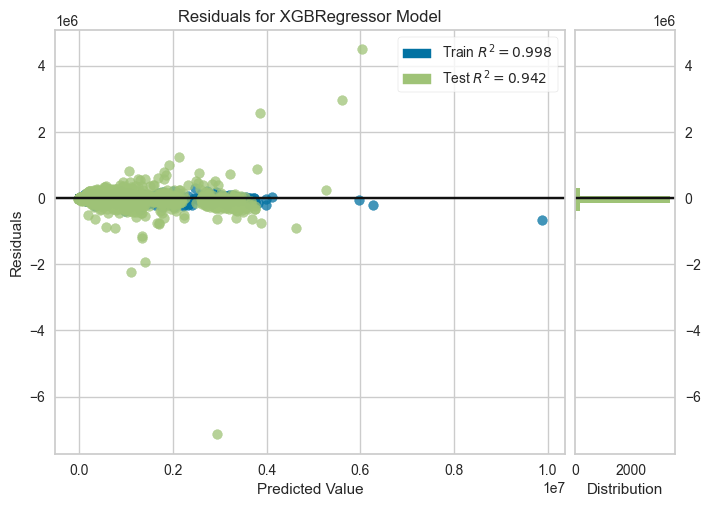

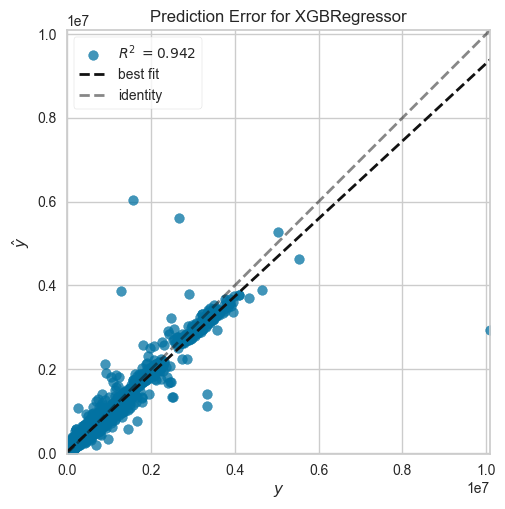

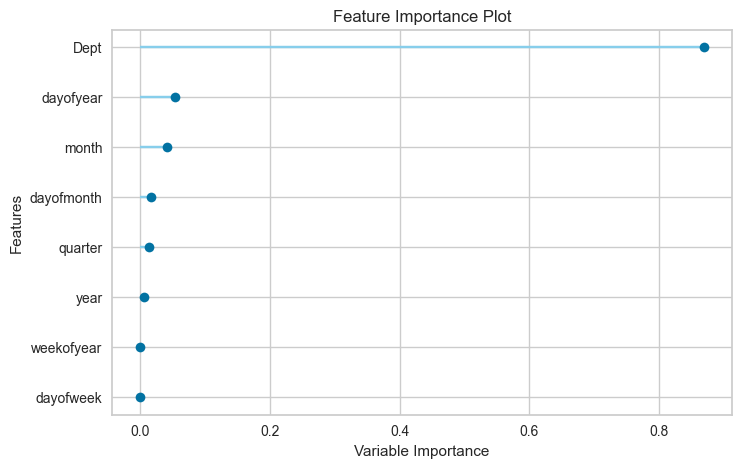

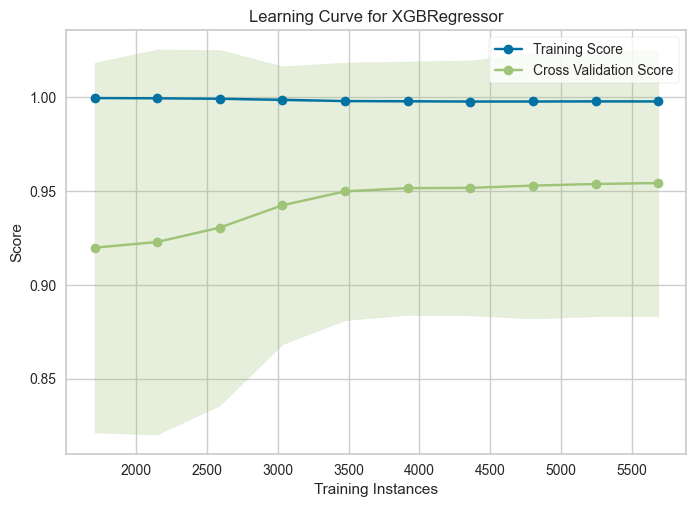

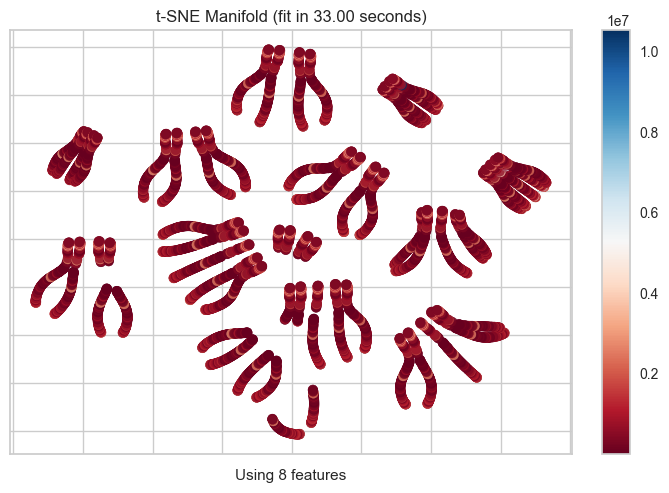

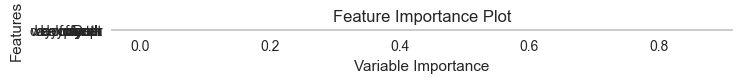

Parameters
objective                reg:squarederror
base_score                           None
booster                            gbtree
callbacks                            None
colsample_bylevel                    None
colsample_bynode                     None
colsample_bytree                     None
device                                cpu
early_stopping_rounds                None
enable_categorical                  False
eval_metric                          None
feature_types                        None
gamma                                None
grow_policy                          None
importance_type                      None
interaction_constraints              None
learning_rate                        None
max_bin                              None
max_cat_threshold                    None
max_cat_to_onehot                    None
max_delta_step                       None
max_depth                            None
max_leaves                           None
min_child_weight                     None
missing                               nan
monotone_constraints                 None
multi_strategy                       None
n_estimators                         None
n_jobs                                 -1
num_parallel_tree                    None
random_state                         8680
reg_alpha                            None
reg_lambda                           None
sampling_method                      None
scale_pos_weight                     None
subsample                            None
tree_method                          auto
validate_parameters                  None
verbosity                               0


 
 >>plotting is  DONE! 
 

Pipeline(memory=Memory(location=None),
         steps=[('placeholder', None),
                ('actual_estimator',
                 XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=None, device='cpu',
                              early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
               


 
 >>predict_model(final_mdl) for Model:xgboost IS  DONE! 
 




 
 >>pred_mdl = predict_model(final_mdl, data=test) for Model:xgboost IS  DONE! 
 


 
 >> Prediction of Model:xgboost  IS  DONE!



 
 >>mdll = create_model(mdl) for Model:catboost IS  DONE! 
 



Fitting 10 folds for each of 10 candidates, totalling 100 fits

 
 >>tuned_mdl = tune_model(mdll) for Model:catboost IS  DONE! 
 




 
 >>predict_model(tuned_mdl) for Model:catboost IS  DONE! 
 


 
 >>final_mdl = finalize_model(tuned_mdl) for Model:catboost IS  DONE! 
 



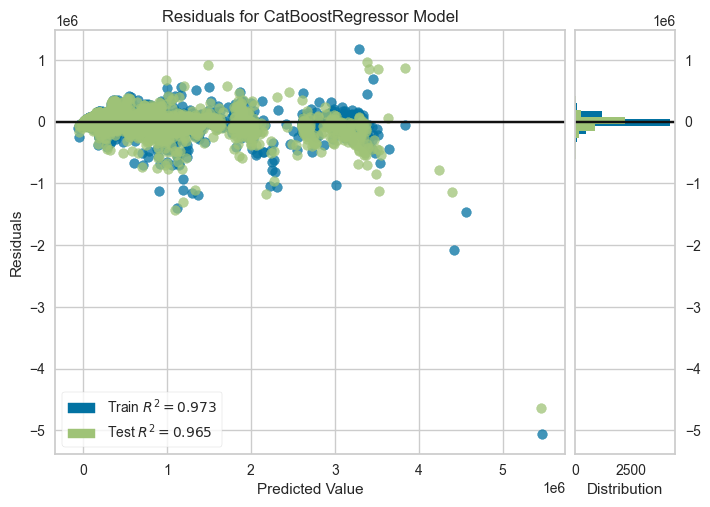

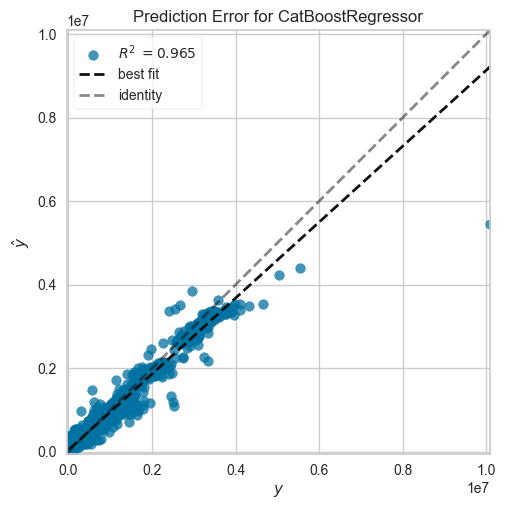

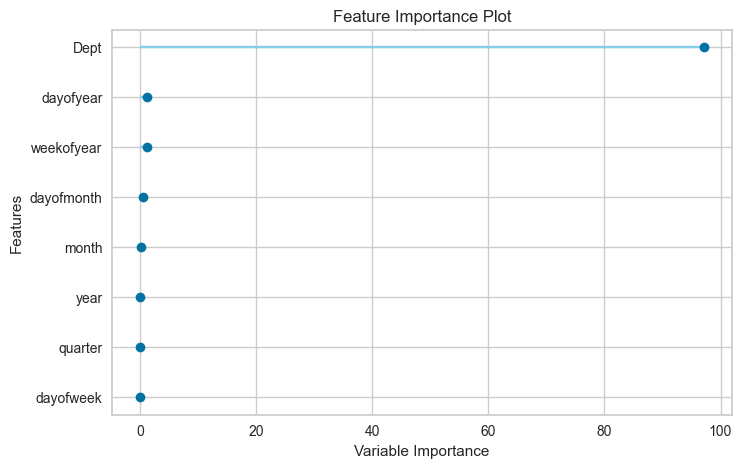

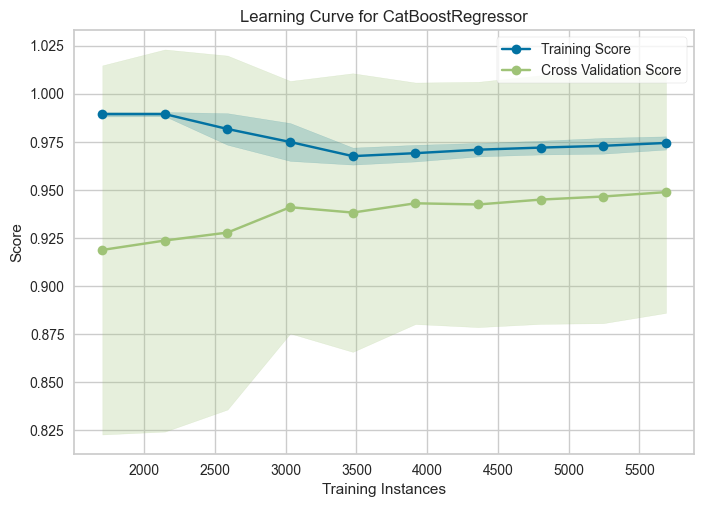

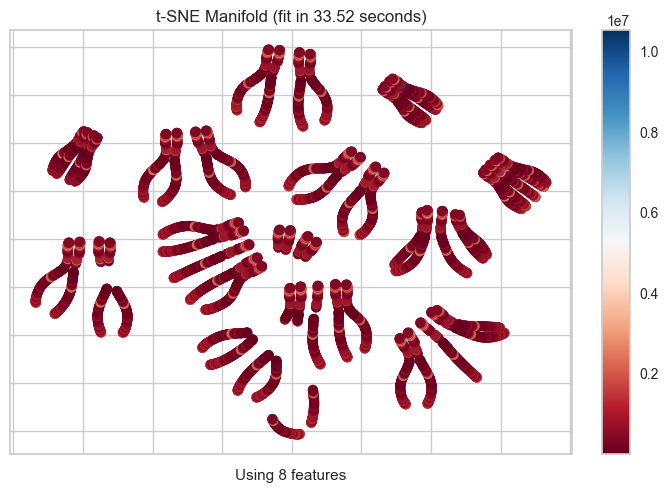

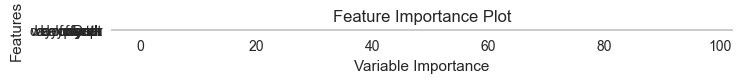

Parameters
nan_mode                                                   Min
eval_metric                                               RMSE
iterations                                                 210
sampling_frequency                                     PerTree
leaf_estimation_method                                  Newton
random_score_type                  NormalWithModelSizeDecrease
grow_policy                                      SymmetricTree
penalties_coefficient                                        1
boosting_type                                            Plain
model_shrink_mode                                     Constant
feature_border_type                               GreedyLogSum
bayesian_matrix_reg                        0.10000000149011612
eval_fraction                                                0
force_unit_auto_pair_weights                             False
l2_leaf_reg                                                  9
random_strength                            0.20000000298023224
rsm                                                          1
boost_from_average                                        True
model_size_reg                                             0.5
pool_metainfo_options                             {'tags': {}}
subsample                                    0.800000011920929
use_best_model                                           False
random_seed                                               8680
depth                                                        6
posterior_sampling                                       False
border_count                                               254
classes_count                                                0
auto_class_weights                                        None
sparse_features_conflict_fraction                            0
leaf_estimation_backtracking                    AnyImprovement
best_model_min_trees                                         1
model_shrink_rate                                            0
min_data_in_leaf                                             1
loss_function                                             RMSE
learning_rate                              0.20000000298023224
score_function                                          Cosine
task_type                                                  CPU
leaf_estimation_iterations                                   1
bootstrap_type                                             MVS
max_leaves                                                  64


 
 >>plotting is  DONE! 
 

Pipeline(memory=Memory(location=None),
         steps=[('placeholder', None),
                ('actual_estimator',
                 <catboost.core.CatBoostRegressor object at 0x00000268BE0A6150>)])

 
 >>print(final_mdl) for Model:catboost IS  DONE! 
 




 
 >>predict_model(final_mdl) for Model:catboost IS  DONE! 
 




 
 >>pred_mdl = predict_model(final_mdl, data=test) for Model:catboost IS  DONE! 
 


 
 >> Prediction of Model:catboost  IS  DONE!



 
 >>mdll = create_model(mdl) for Model:tr IS  DONE! 
 



Fitting 10 folds for each of 2 candidates, totalling 20 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).

 
 >>tuned_mdl = tune_model(mdll) for Model:tr IS  DONE! 
 




 
 >>predict_model(tuned_mdl) for Model:tr IS  DONE! 
 


 
 >>final_mdl = finalize_model(tuned_mdl) for Model:tr IS  DONE! 
 



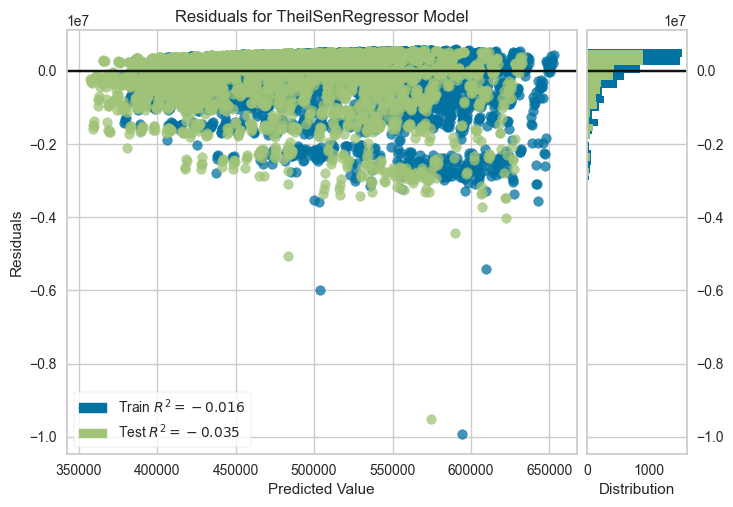

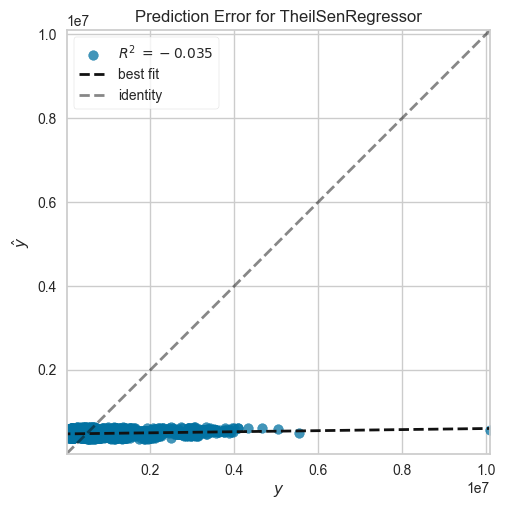

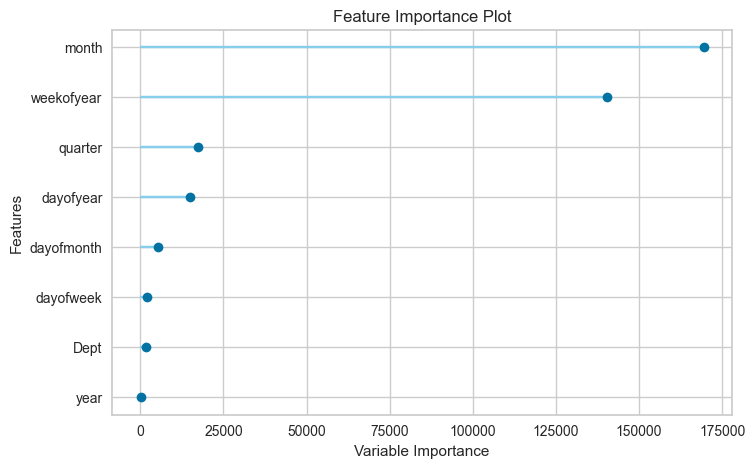

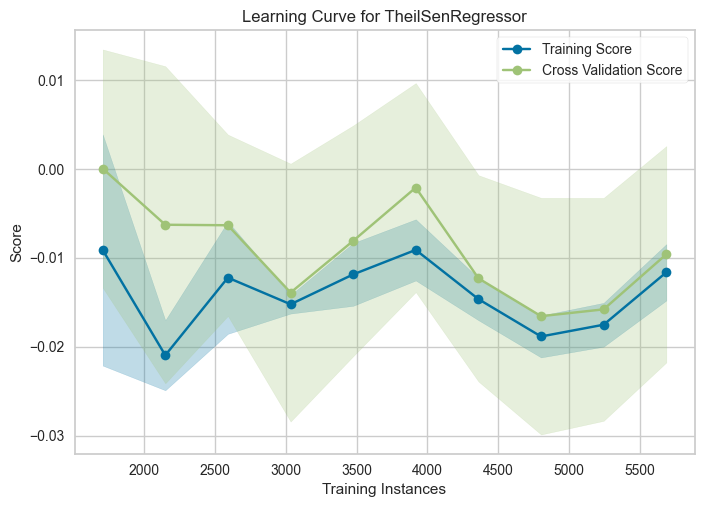

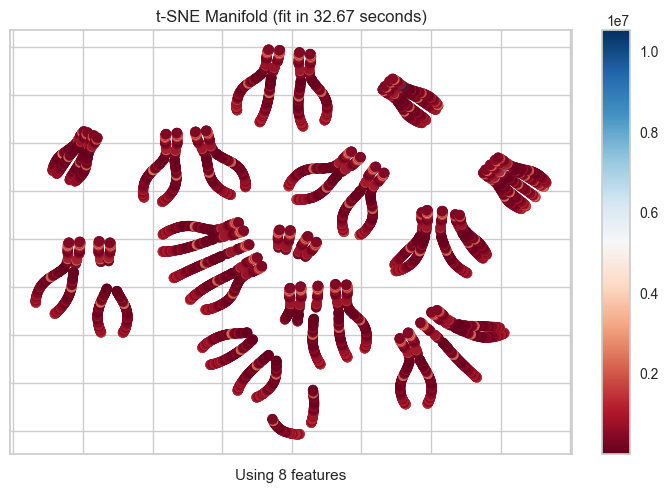

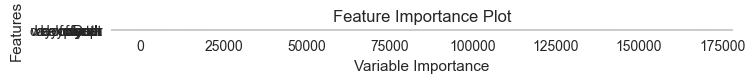

Parameters
copy_X                  True
fit_intercept           True
max_iter                1000
max_subpopulation    10000.0
n_jobs                    -1
n_subsamples            None
random_state            8680
tol                    0.001
verbose                False


 
 >>plotting is  DONE! 
 

Pipeline(memory=Memory(location=None),
         steps=[('placeholder', None),
                ('actual_estimator',
                 TheilSenRegressor(max_iter=1000, n_jobs=-1,
                                   random_state=8680))])

 
 >>print(final_mdl) for Model:tr IS  DONE! 
 




 
 >>predict_model(final_mdl) for Model:tr IS  DONE! 
 




 
 >>pred_mdl = predict_model(final_mdl, data=test) for Model:tr IS  DONE! 
 


 
 >> Prediction of Model:tr  IS  DONE!



 
 >>mdll = create_model(mdl) for Model:lightgbm IS  DONE! 
 



Fitting 10 folds for each of 10 candidates, totalling 100 fits

 
 >>tuned_mdl = tune_model(mdll) for Model:lightgbm IS  DONE! 
 



[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4

 
 >>predict_model(tuned_mdl) for Model:lightgbm IS  DONE! 
 


 
 >>final_mdl = finalize_model(tuned_mdl) for Model:lightgbm IS  DONE! 
 



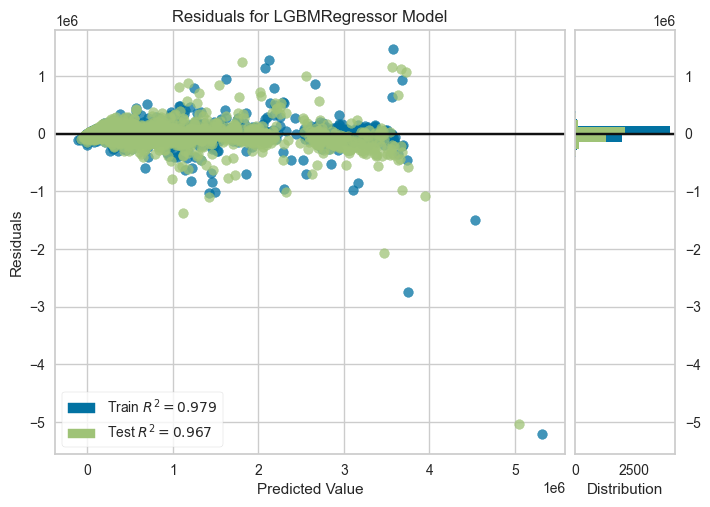

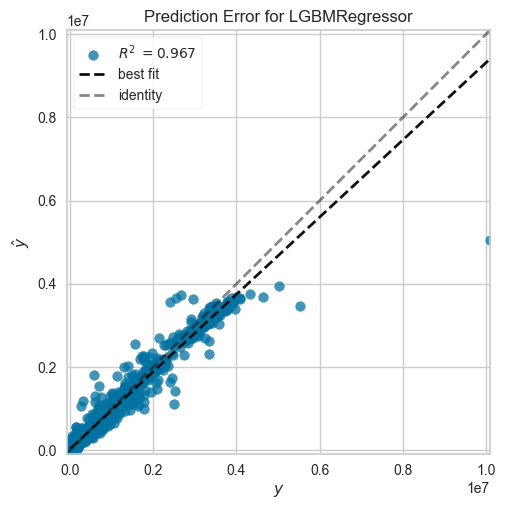

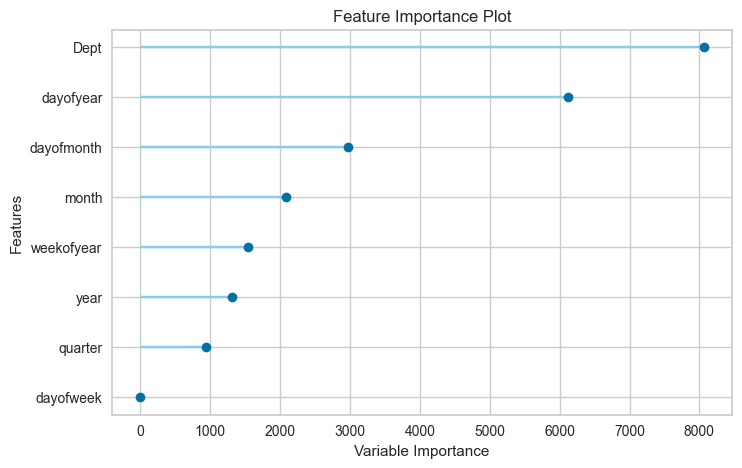

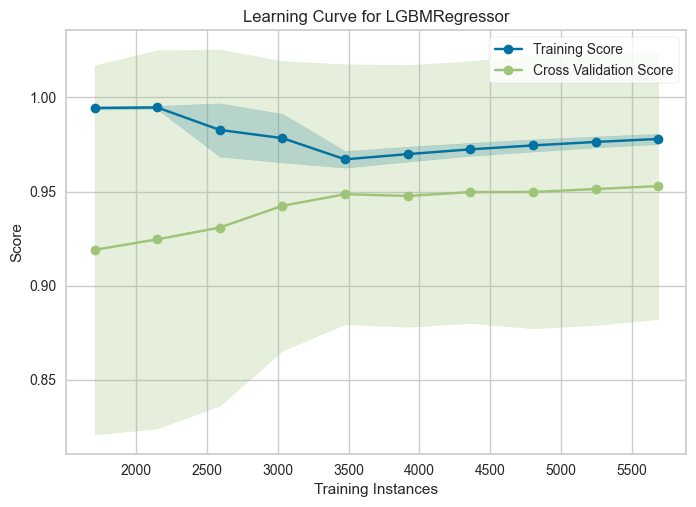

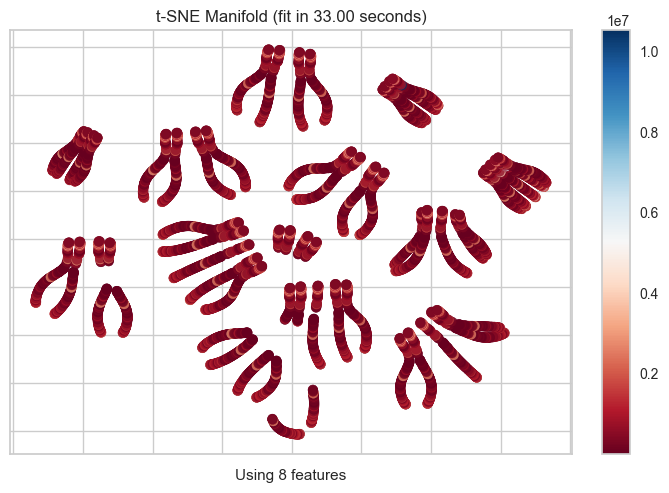

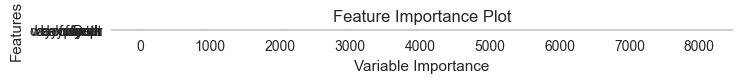

Parameters
boosting_type           gbdt
class_weight            None
colsample_bytree         1.0
importance_type        split
learning_rate           0.05
max_depth                 -1
min_child_samples          6
min_child_weight       0.001
min_split_gain           0.9
n_estimators             260
n_jobs                    -1
num_leaves                90
objective               None
random_state            8680
reg_alpha                0.3
reg_lambda             0.001
subsample                1.0
subsample_for_bin     200000
subsample_freq             0
feature_fraction         0.6
bagging_freq               4
bagging_fraction         0.5


 
 >>plotting is  DONE! 
 

Pipeline(memory=Memory(location=None),
         steps=[('placeholder', None),
                ('actual_estimator',
                 LGBMRegressor(bagging_fraction=0.5, bagging_freq=4,
                               feature_fraction=0.6, learning_rate=0.05,
                               min_child_samples=6, min_split_gain=0.9,
                               n_estimators=260, n_jobs=-1, num_leaves=90,
                               random_state=8680, reg_alpha=0.3,
                               reg_lambda=0.001))])

 
 >>print(final_mdl) for Model:lightgbm IS  DONE! 
 



[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4

 
 >>predict_model(final_mdl) for Model:lightgbm IS  DONE! 
 



[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4

 
 >>pred_mdl = predict_model(final_mdl, data=test) for Model:lightgbm IS  DONE! 
 


 
 >> Prediction of Model:lightgbm  IS  DONE!



 
 >>mdll = create_model(mdl) for Model:gbr IS  DONE! 
 



Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).

 
 >>tuned_mdl = tune_model(mdll) for Model:gbr IS  DONE! 
 




 
 >>predict_model(tuned_mdl) for Model:gbr IS  DONE! 
 


 
 >>final_mdl = finalize_model(tuned_mdl) for Model:gbr IS  DONE! 
 



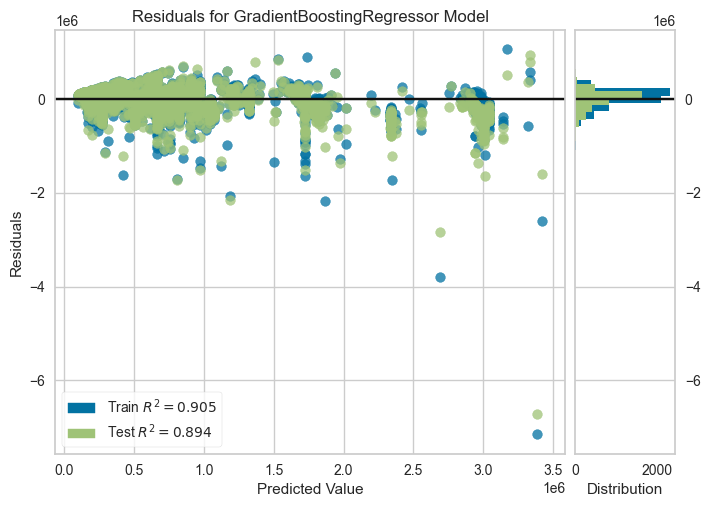

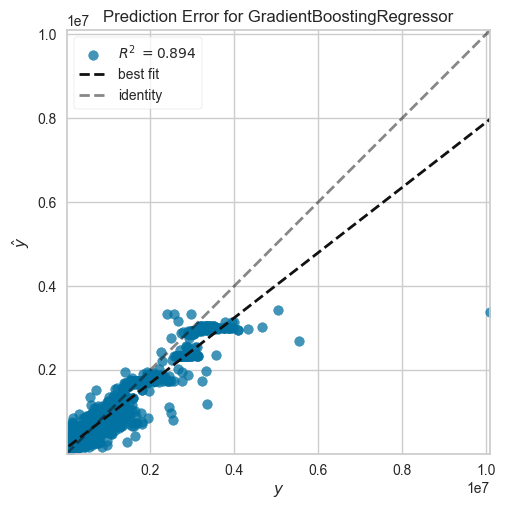

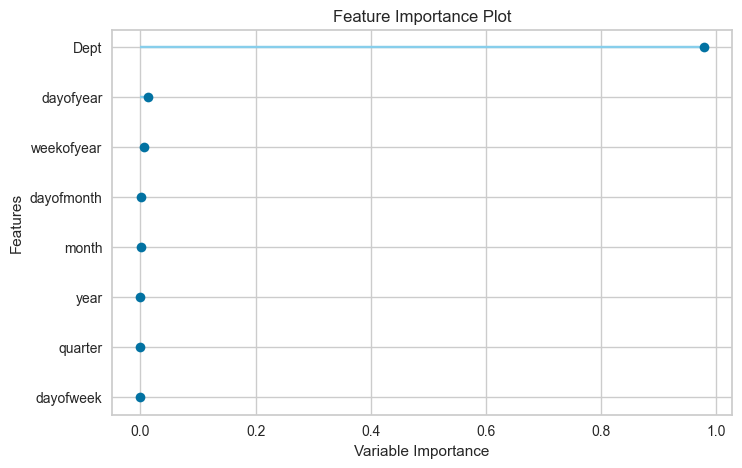

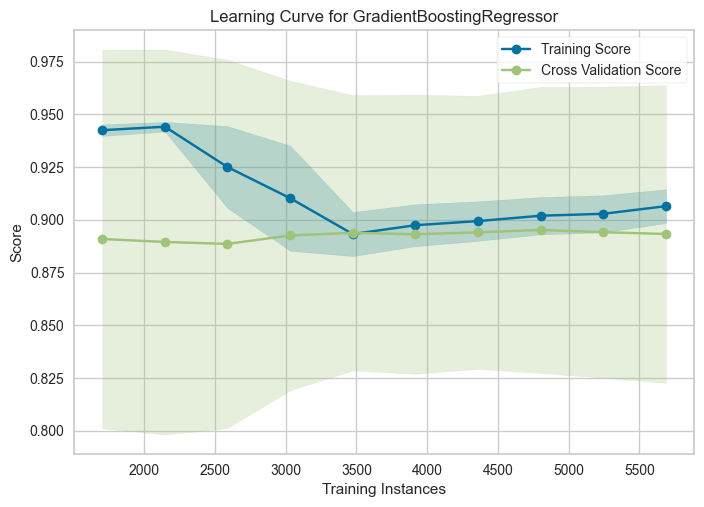

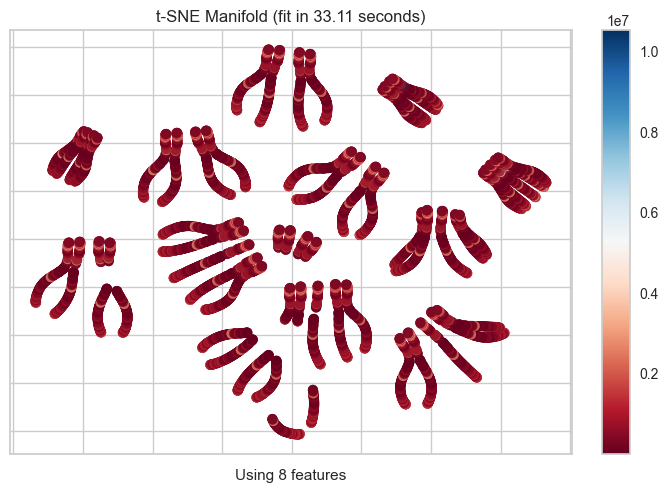

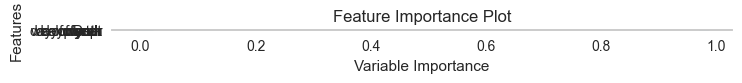

Parameters
alpha                               0.9
ccp_alpha                           0.0
criterion                  friedman_mse
init                               None
learning_rate                       0.1
loss                      squared_error
max_depth                             3
max_features                       None
max_leaf_nodes                     None
min_impurity_decrease               0.0
min_samples_leaf                      1
min_samples_split                     2
min_weight_fraction_leaf            0.0
n_estimators                        100
n_iter_no_change                   None
random_state                       8680
subsample                           1.0
tol                              0.0001
validation_fraction                 0.1
verbose                               0
warm_start                        False


 
 >>plotting is  DONE! 
 

Pipeline(memory=Memory(location=None),
         steps=[('placeholder', None),
                ('actual_estimator',
                 GradientBoostingRegressor(random_state=8680))])

 
 >>print(final_mdl) for Model:gbr IS  DONE! 
 




 
 >>predict_model(final_mdl) for Model:gbr IS  DONE! 
 




 
 >>pred_mdl = predict_model(final_mdl, data=test) for Model:gbr IS  DONE! 
 


 
 >> Prediction of Model:gbr  IS  DONE!



 
 >>mdll = create_model(mdl) for Model:huber IS  DONE! 
 



Fitting 10 folds for each of 10 candidates, totalling 100 fits

 
 >>tuned_mdl = tune_model(mdll) for Model:huber IS  DONE! 
 




 
 >>predict_model(tuned_mdl) for Model:huber IS  DONE! 
 


 
 >>final_mdl = finalize_model(tuned_mdl) for Model:huber IS  DONE! 
 



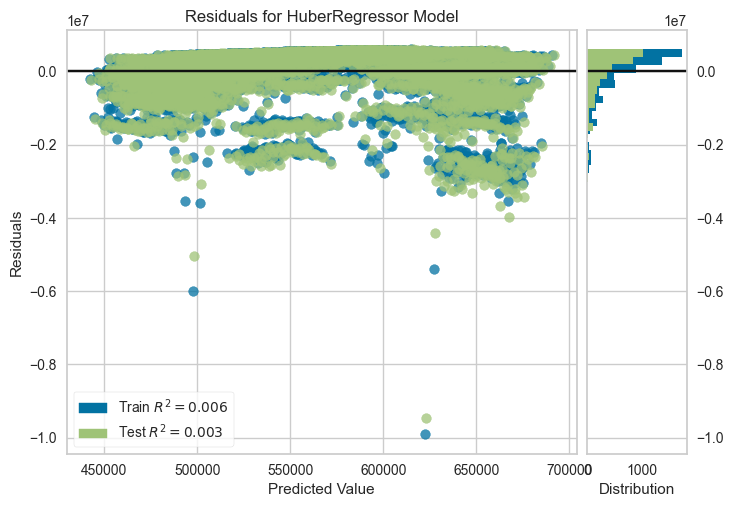

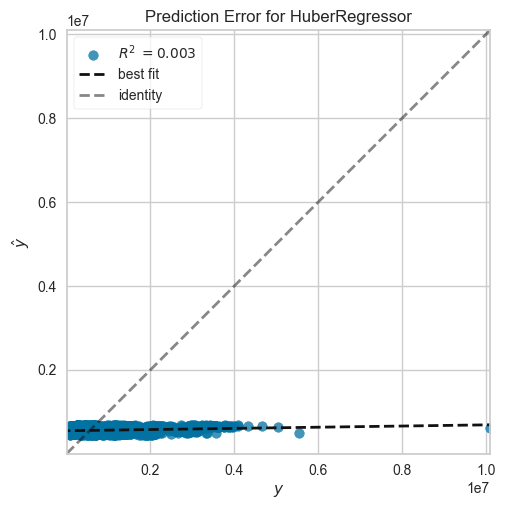

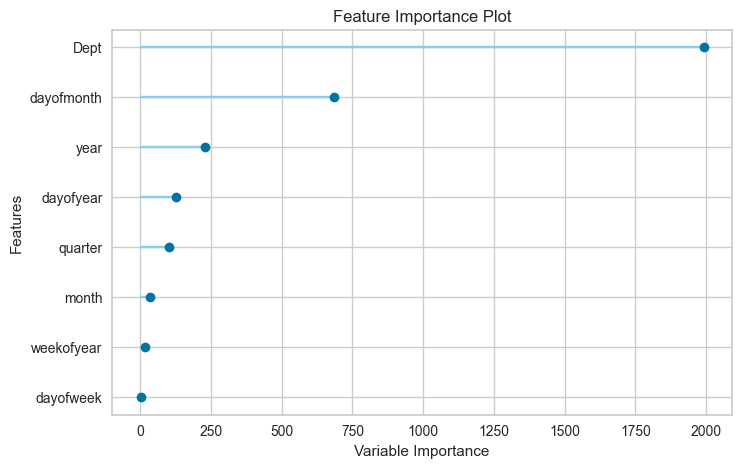

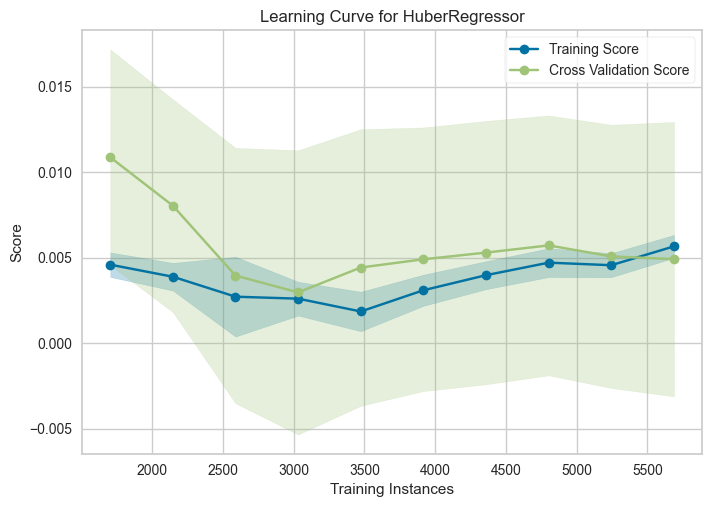

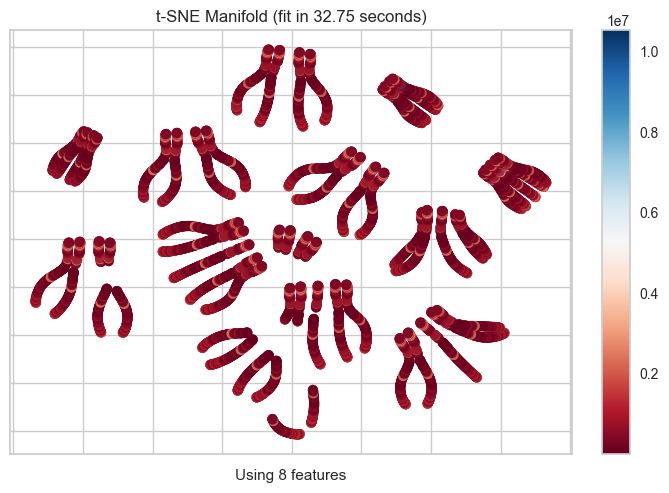

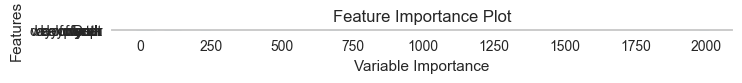

Parameters
alpha                0.2
epsilon              1.9
fit_intercept       True
max_iter             100
tol                1e-05
warm_start         False


 
 >>plotting is  DONE! 
 

Pipeline(memory=Memory(location=None),
         steps=[('placeholder', None),
                ('actual_estimator', HuberRegressor(alpha=0.2, epsilon=1.9))])

 
 >>print(final_mdl) for Model:huber IS  DONE! 
 




 
 >>predict_model(final_mdl) for Model:huber IS  DONE! 
 




 
 >>pred_mdl = predict_model(final_mdl, data=test) for Model:huber IS  DONE! 
 


 
 >> Prediction of Model:huber  IS  DONE!



 
 >>mdll = create_model(mdl) for Model:ada IS  DONE! 
 



Fitting 10 folds for each of 10 candidates, totalling 100 fits

 
 >>tuned_mdl = tune_model(mdll) for Model:ada IS  DONE! 
 




 
 >>predict_model(tuned_mdl) for Model:ada IS  DONE! 
 


 
 >>final_mdl = finalize_model(tuned_mdl) for Model:ada IS  DONE! 
 



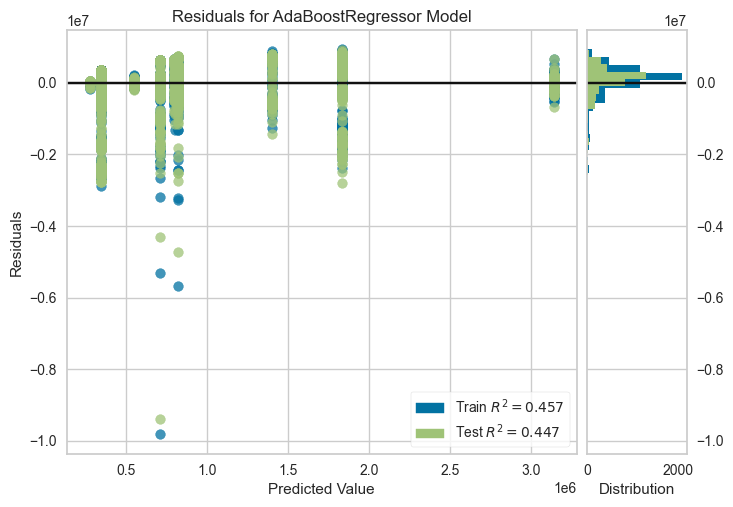

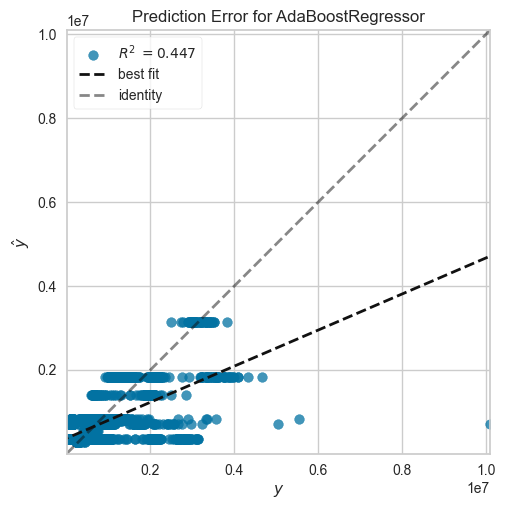

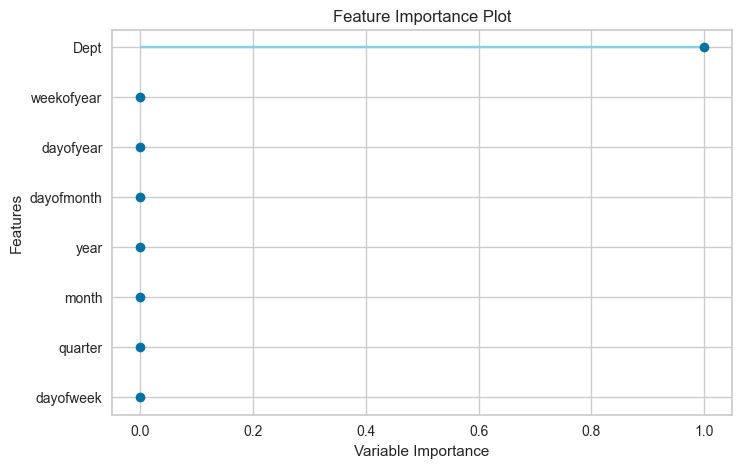

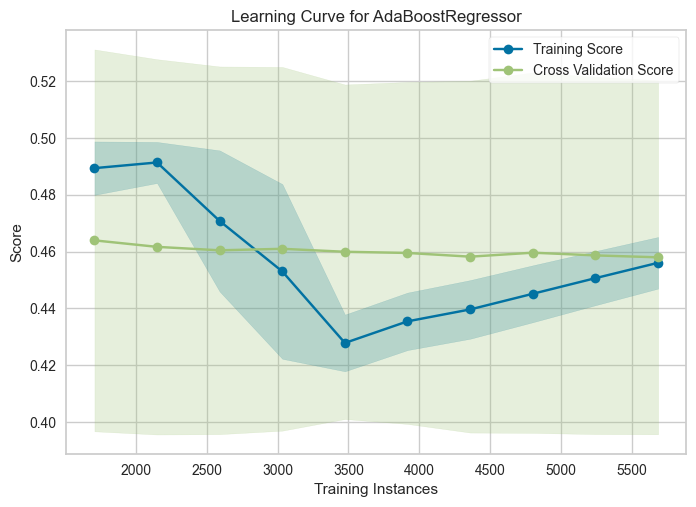

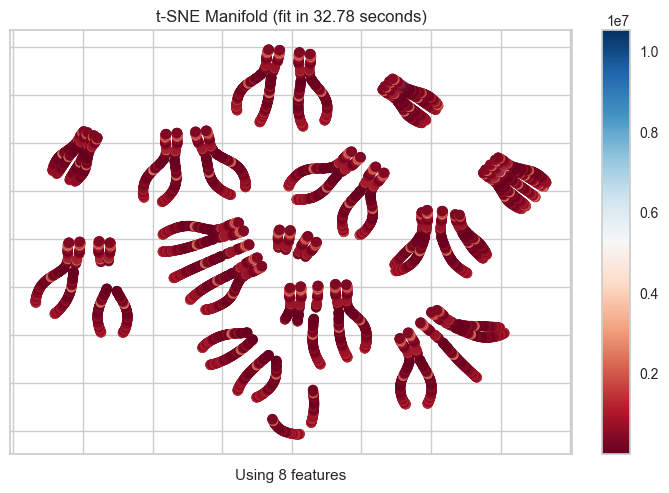

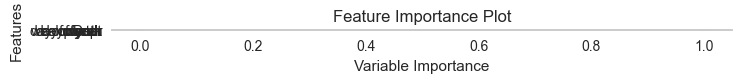

Parameters
base_estimator  deprecated
estimator             None
learning_rate       0.0001
loss                linear
n_estimators           190
random_state          8680


 
 >>plotting is  DONE! 
 

Pipeline(memory=Memory(location=None),
         steps=[('placeholder', None),
                ('actual_estimator',
                 AdaBoostRegressor(learning_rate=0.0001, n_estimators=190,
                                   random_state=8680))])

 
 >>print(final_mdl) for Model:ada IS  DONE! 
 




 
 >>predict_model(final_mdl) for Model:ada IS  DONE! 
 




 
 >>pred_mdl = predict_model(final_mdl, data=test) for Model:ada IS  DONE! 
 


 
 >> Prediction of Model:ada  IS  DONE!



 
 >>mdll = create_model(mdl) for Model:par IS  DONE! 
 



Fitting 10 folds for each of 10 candidates, totalling 100 fits

 
 >>tuned_mdl = tune_model(mdll) for Model:par IS  DONE! 
 




 
 >>predict_model(tuned_mdl) for Model:par IS  DONE! 
 


 
 >>final_mdl = finalize_model(tuned_mdl) for Model:par IS  DONE! 
 



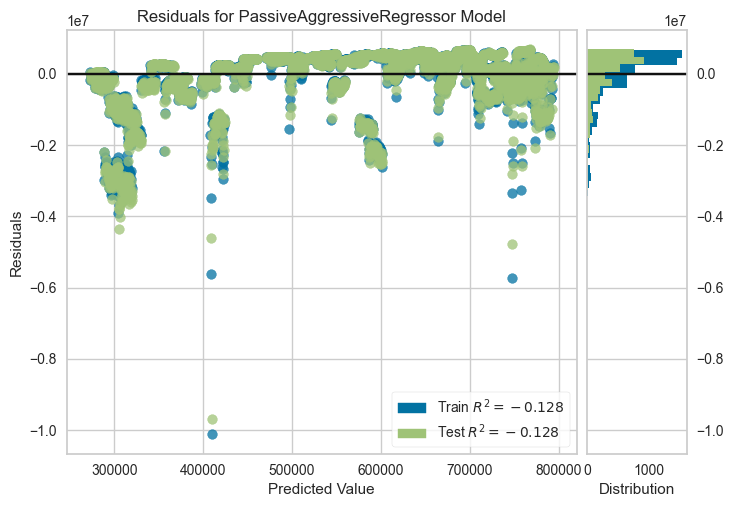

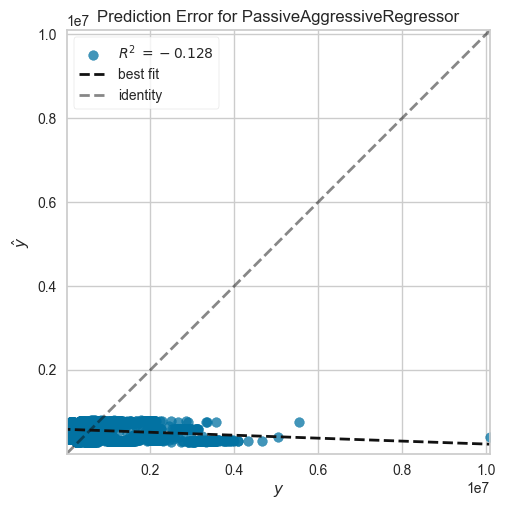

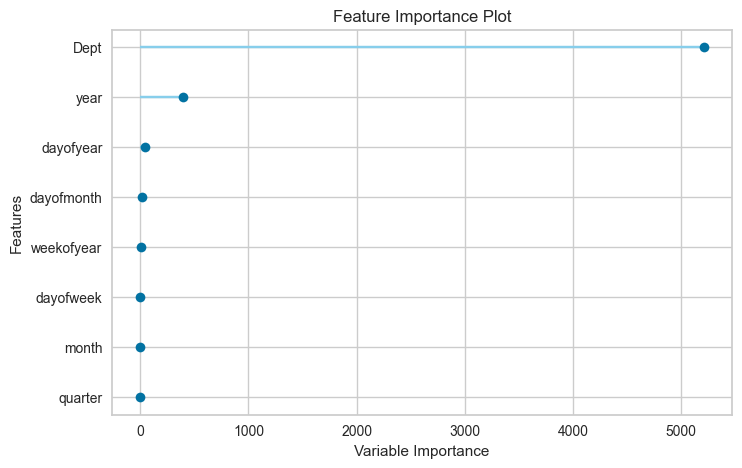

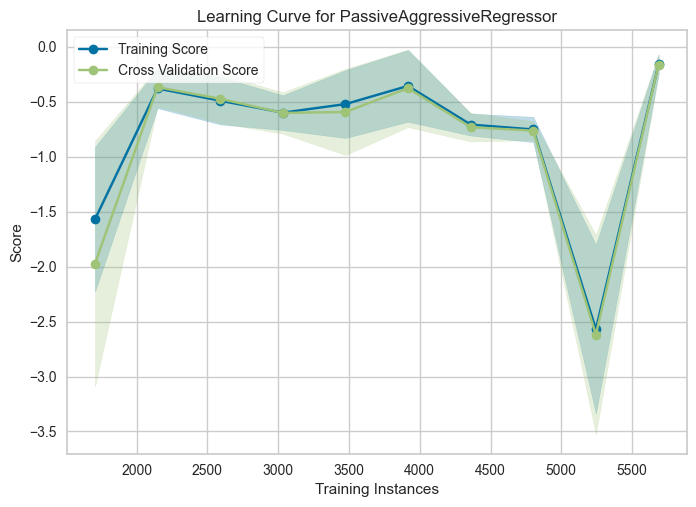

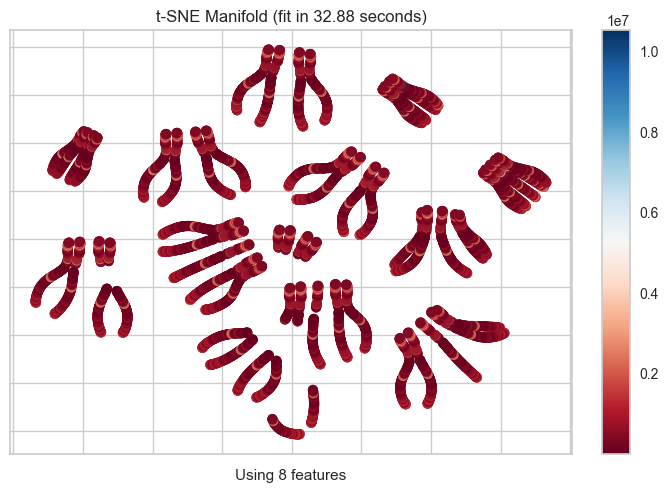

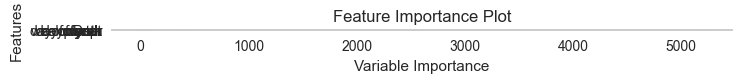

Parameters
C                                          5.736
average                                    False
early_stopping                             False
epsilon                                      0.8
fit_intercept                              False
loss                 squared_epsilon_insensitive
max_iter                                    1000
n_iter_no_change                               5
random_state                                8680
shuffle                                    False
tol                                        0.001
validation_fraction                          0.1
verbose                                        0
warm_start                                 False


 
 >>plotting is  DONE! 
 

Pipeline(memory=Memory(location=None),
         steps=[('placeholder', None),
                ('actual_estimator',
                 PassiveAggressiveRegressor(C=5.736, epsilon=0.8,
                                            fit_intercept=False,
                                            loss='squared_epsilon_insensitive',
                                            random_state=8680,
                                            shuffle=False))])

 
 >>print(final_mdl) for Model:par IS  DONE! 
 




 
 >>predict_model(final_mdl) for Model:par IS  DONE! 
 




 
 >>pred_mdl = predict_model(final_mdl, data=test) for Model:par IS  DONE! 
 


 
 >> Prediction of Model:par  IS  DONE!



 
 >>mdll = create_model(mdl) for Model:omp IS  DONE! 
 



Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).

 
 >>tuned_mdl = tune_model(mdll) for Model:omp IS  DONE! 
 




 
 >>predict_model(tuned_mdl) for Model:omp IS  DONE! 
 


 
 >>final_mdl = finalize_model(tuned_mdl) for Model:omp IS  DONE! 
 



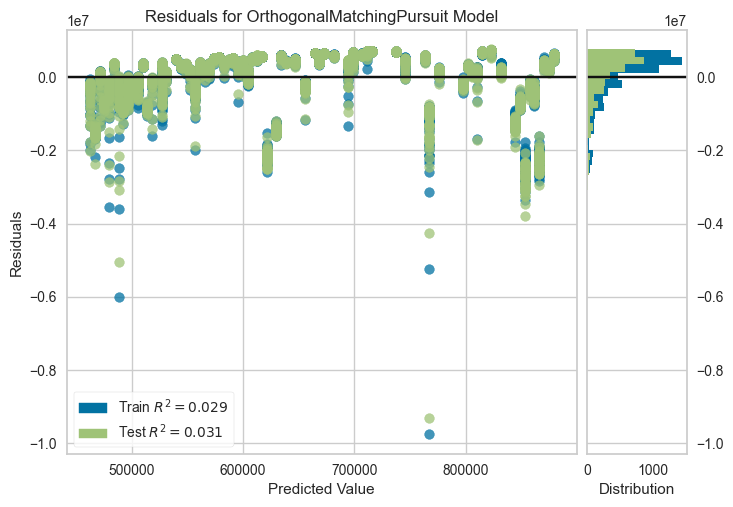

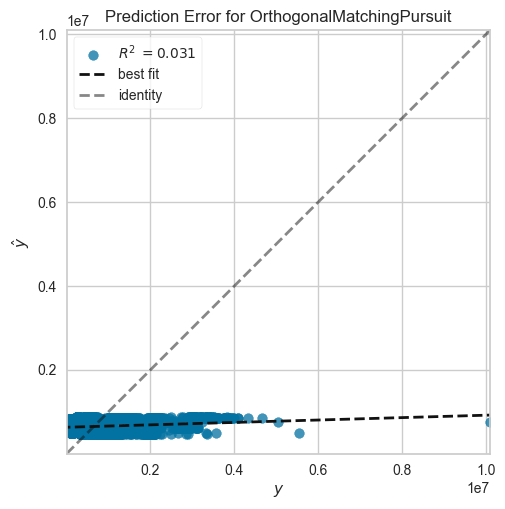

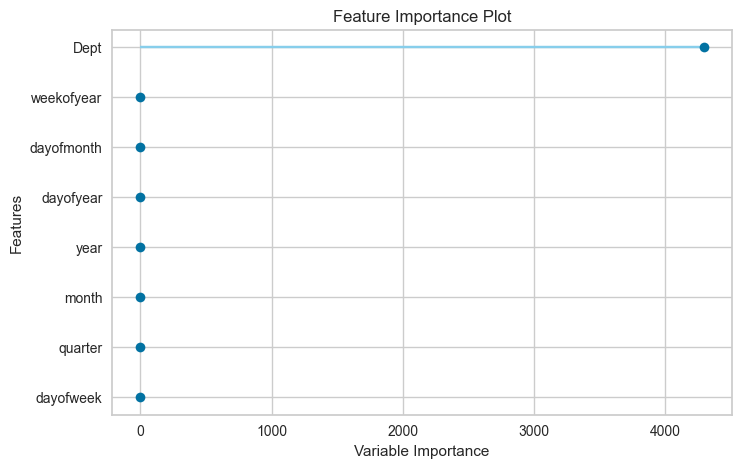

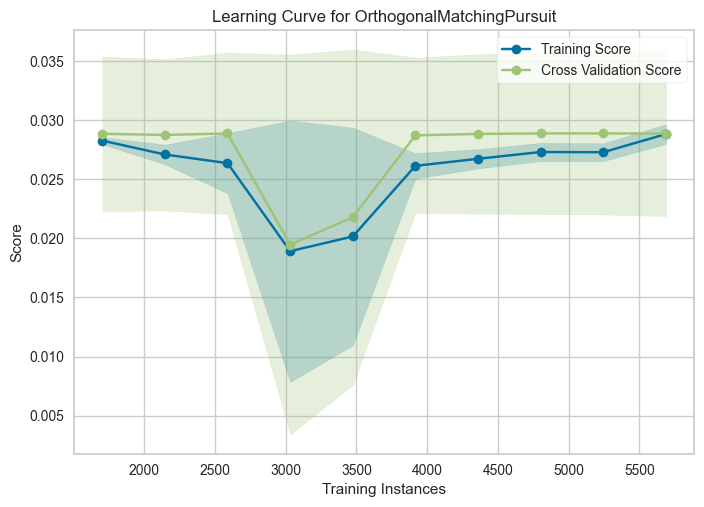

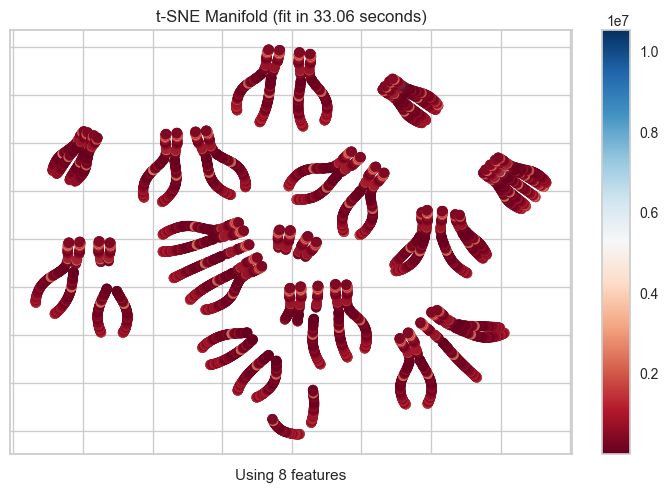

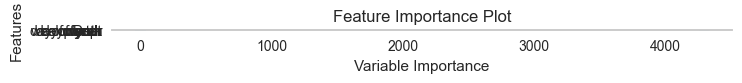

Parameters
fit_intercept          True
n_nonzero_coefs        None
normalize        deprecated
precompute             auto
tol                    None


 
 >>plotting is  DONE! 
 

Pipeline(memory=Memory(location=None),
         steps=[('placeholder', None),
                ('actual_estimator', OrthogonalMatchingPursuit())])

 
 >>print(final_mdl) for Model:omp IS  DONE! 
 




 
 >>predict_model(final_mdl) for Model:omp IS  DONE! 
 




 
 >>pred_mdl = predict_model(final_mdl, data=test) for Model:omp IS  DONE! 
 


 
 >> Prediction of Model:omp  IS  DONE!



 
 >>mdll = create_model(mdl) for Model:en IS  DONE! 
 



Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).

 
 >>tuned_mdl = tune_model(mdll) for Model:en IS  DONE! 
 




 
 >>predict_model(tuned_mdl) for Model:en IS  DONE! 
 


 
 >>final_mdl = finalize_model(tuned_mdl) for Model:en IS  DONE! 
 



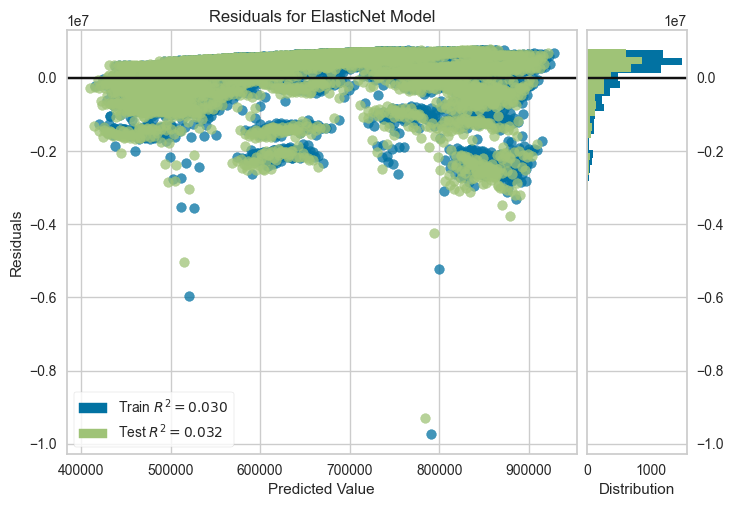

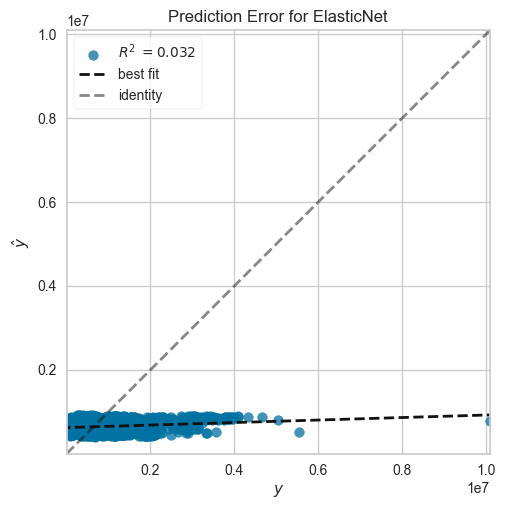

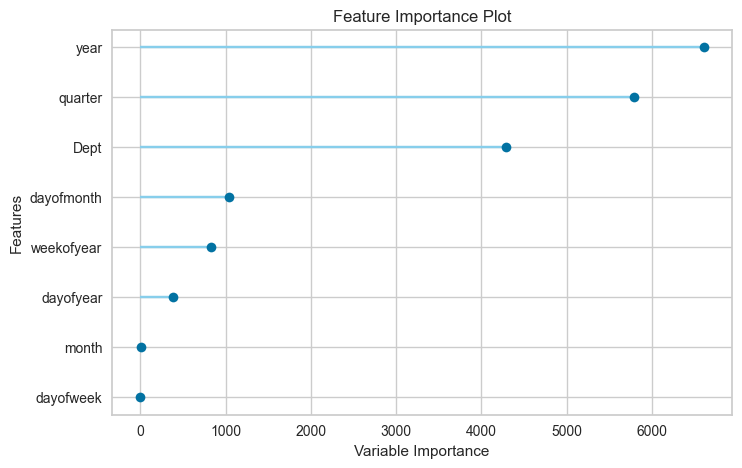

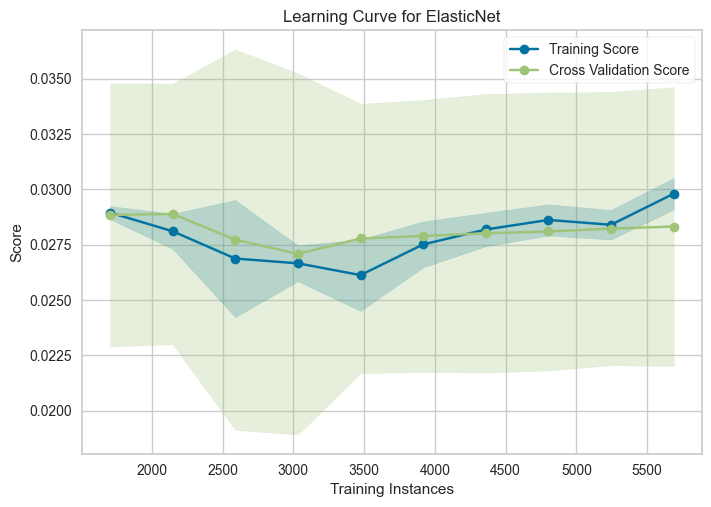

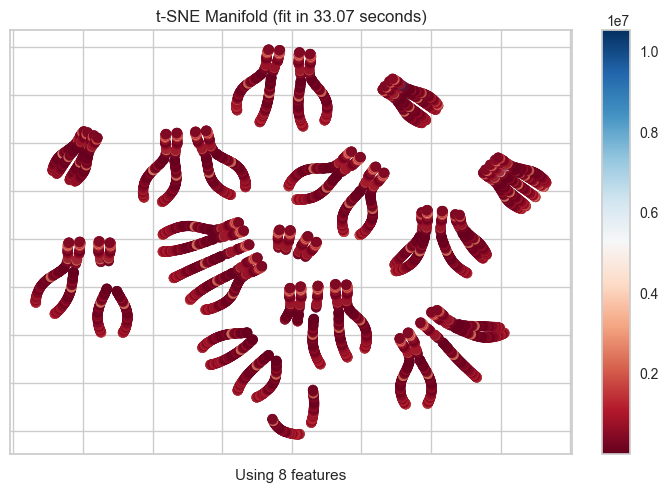

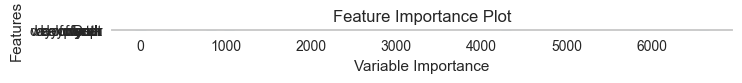

Parameters
alpha                1.0
copy_X              True
fit_intercept       True
l1_ratio             0.5
max_iter            1000
positive           False
precompute         False
random_state        8680
selection         cyclic
tol               0.0001
warm_start         False


 
 >>plotting is  DONE! 
 

Pipeline(memory=Memory(location=None),
         steps=[('placeholder', None),
                ('actual_estimator', ElasticNet(random_state=8680))])

 
 >>print(final_mdl) for Model:en IS  DONE! 
 




 
 >>predict_model(final_mdl) for Model:en IS  DONE! 
 




 
 >>pred_mdl = predict_model(final_mdl, data=test) for Model:en IS  DONE! 
 


 
 >> Prediction of Model:en  IS  DONE!



 
 >>mdll = create_model(mdl) for Model:lasso IS  DONE! 
 



Fitting 10 folds for each of 10 candidates, totalling 100 fits

 
 >>tuned_mdl = tune_model(mdll) for Model:lasso IS  DONE! 
 




 
 >>predict_model(tuned_mdl) for Model:lasso IS  DONE! 
 


 
 >>final_mdl = finalize_model(tuned_mdl) for Model:lasso IS  DONE! 
 



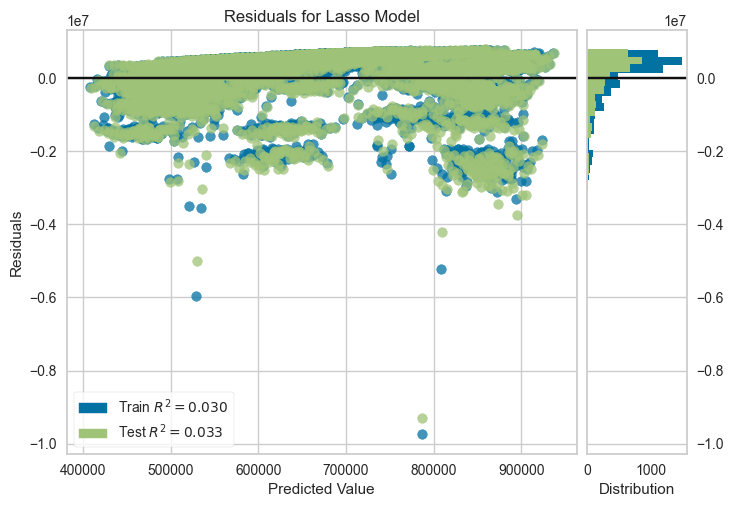

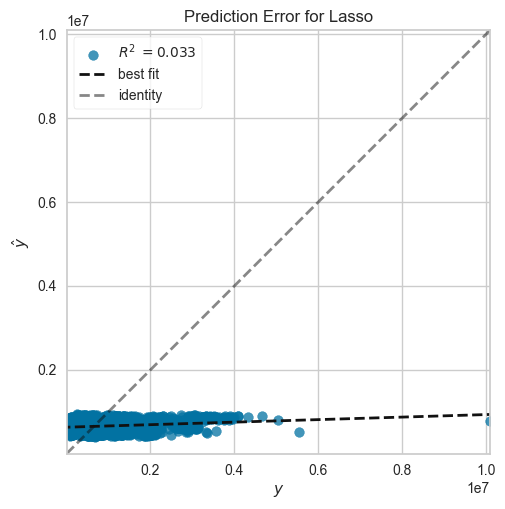

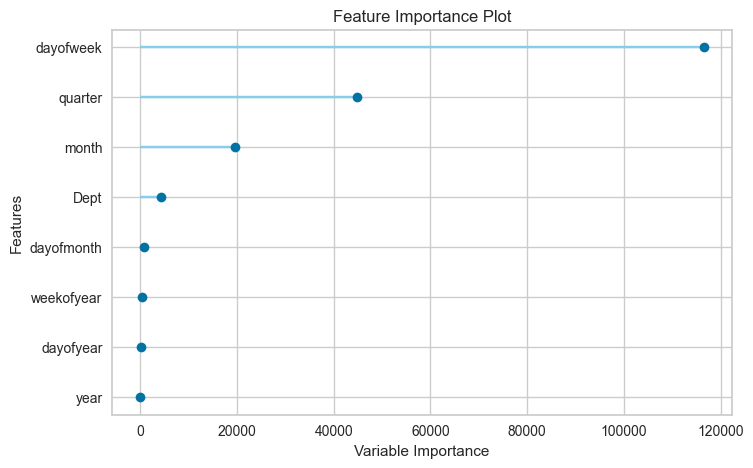

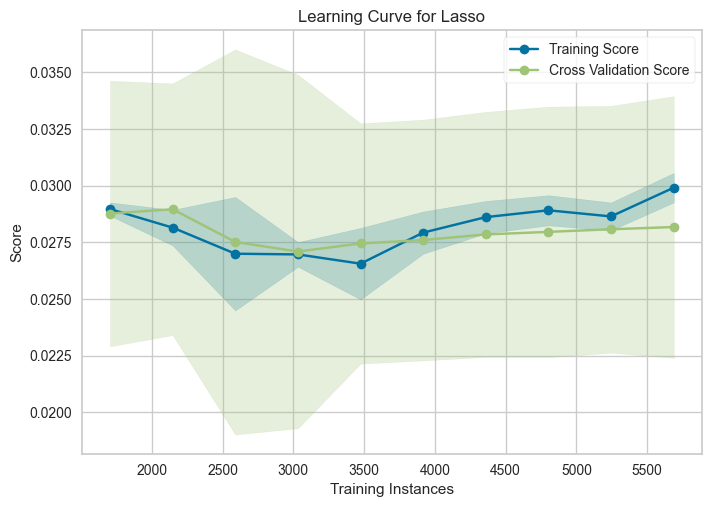

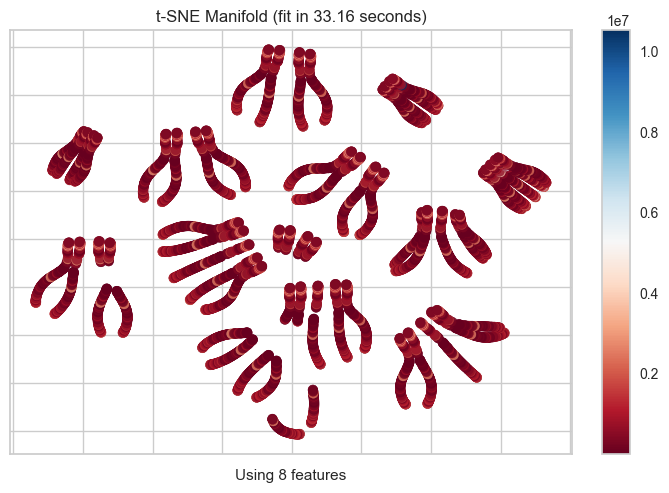

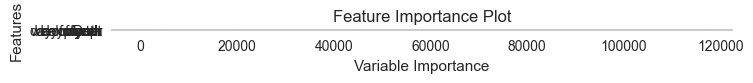

Parameters
alpha               1.07
copy_X              True
fit_intercept      False
max_iter            1000
positive           False
precompute         False
random_state        8680
selection         cyclic
tol               0.0001
warm_start         False


 
 >>plotting is  DONE! 
 

Pipeline(memory=Memory(location=None),
         steps=[('placeholder', None),
                ('actual_estimator',
                 Lasso(alpha=1.07, fit_intercept=False, random_state=8680))])

 
 >>print(final_mdl) for Model:lasso IS  DONE! 
 




 
 >>predict_model(final_mdl) for Model:lasso IS  DONE! 
 




 
 >>pred_mdl = predict_model(final_mdl, data=test) for Model:lasso IS  DONE! 
 


 
 >> Prediction of Model:lasso  IS  DONE!



 
 >>mdll = create_model(mdl) for Model:llar IS  DONE! 
 



Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).

 
 >>tuned_mdl = tune_model(mdll) for Model:llar IS  DONE! 
 




 
 >>predict_model(tuned_mdl) for Model:llar IS  DONE! 
 


 
 >>final_mdl = finalize_model(tuned_mdl) for Model:llar IS  DONE! 
 



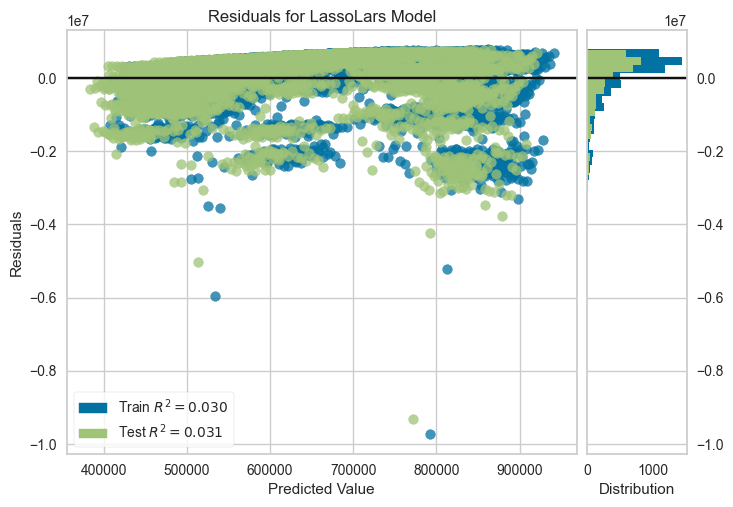

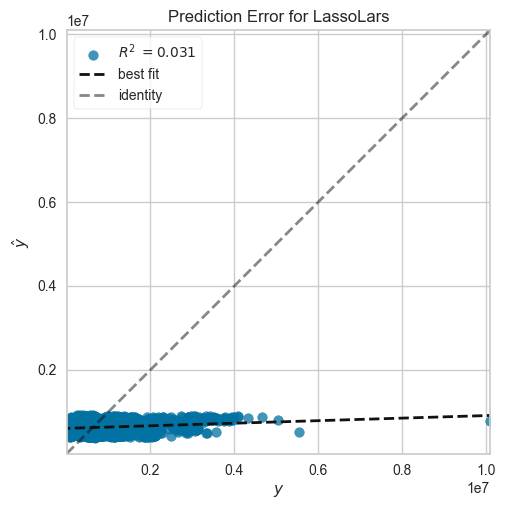

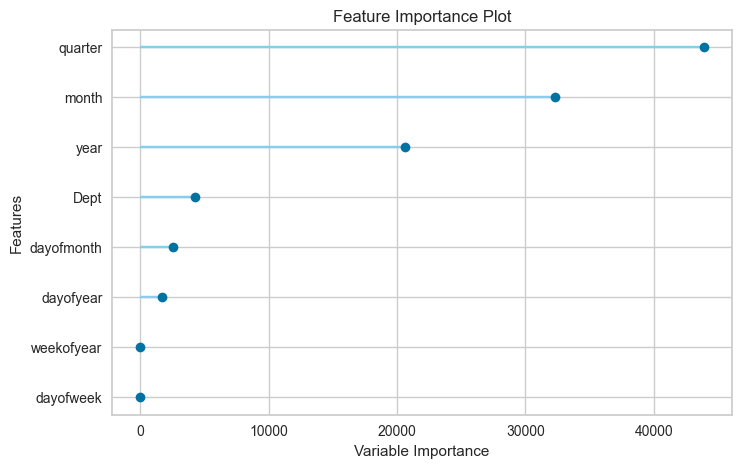

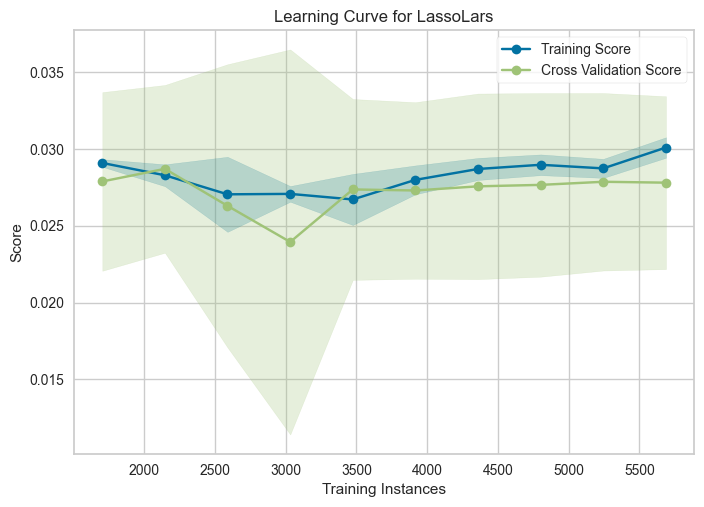

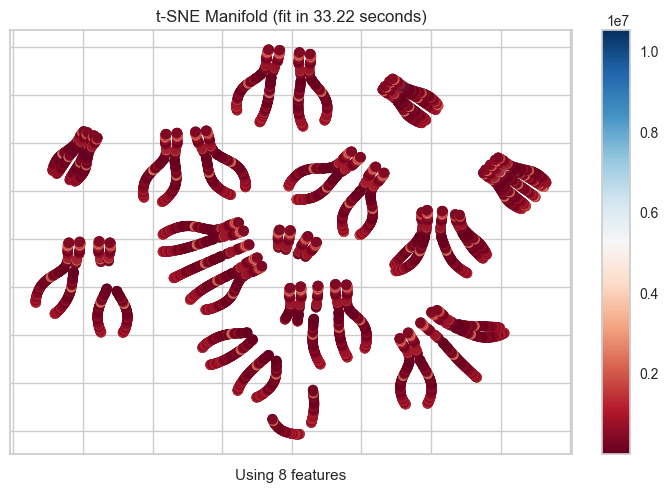

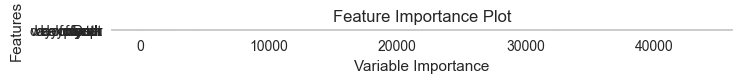

Parameters
alpha                            1.0
copy_X                          True
eps            2.220446049250313e-16
fit_intercept                   True
fit_path                        True
jitter                          None
max_iter                         500
normalize                 deprecated
positive                       False
precompute                      auto
random_state                    8680
verbose                        False


 
 >>plotting is  DONE! 
 

Pipeline(memory=Memory(location=None),
         steps=[('placeholder', None),
                ('actual_estimator', LassoLars(random_state=8680))])

 
 >>print(final_mdl) for Model:llar IS  DONE! 
 




 
 >>predict_model(final_mdl) for Model:llar IS  DONE! 
 




 
 >>pred_mdl = predict_model(final_mdl, data=test) for Model:llar IS  DONE! 
 


 
 >> Prediction of Model:llar  IS  DONE!



 
 >>mdll = create_model(mdl) for Model:br IS  DONE! 
 



Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).

 
 >>tuned_mdl = tune_model(mdll) for Model:br IS  DONE! 
 




 
 >>predict_model(tuned_mdl) for Model:br IS  DONE! 
 


 
 >>final_mdl = finalize_model(tuned_mdl) for Model:br IS  DONE! 
 



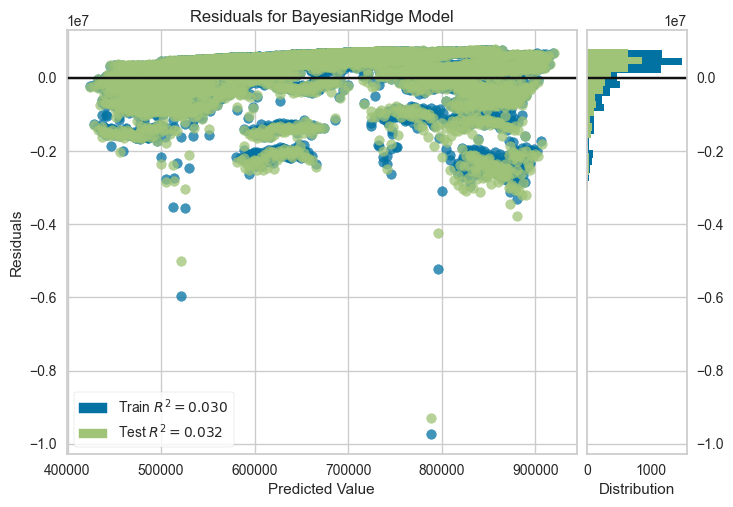

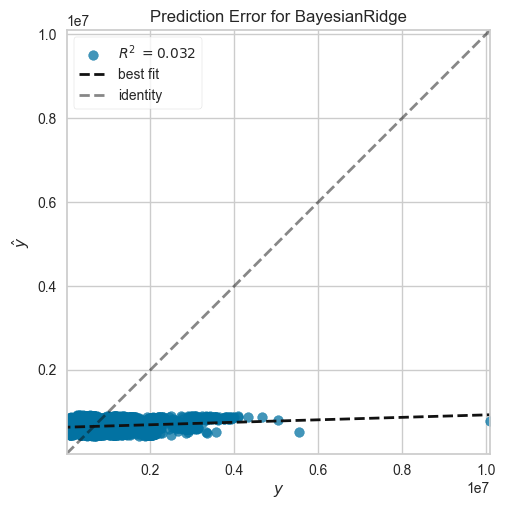

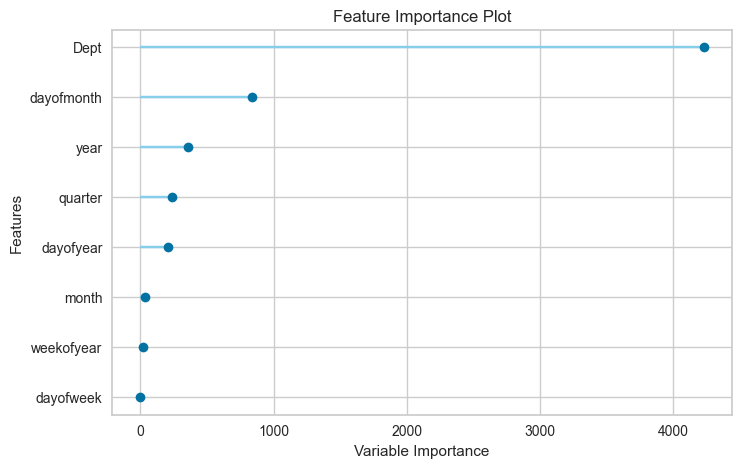

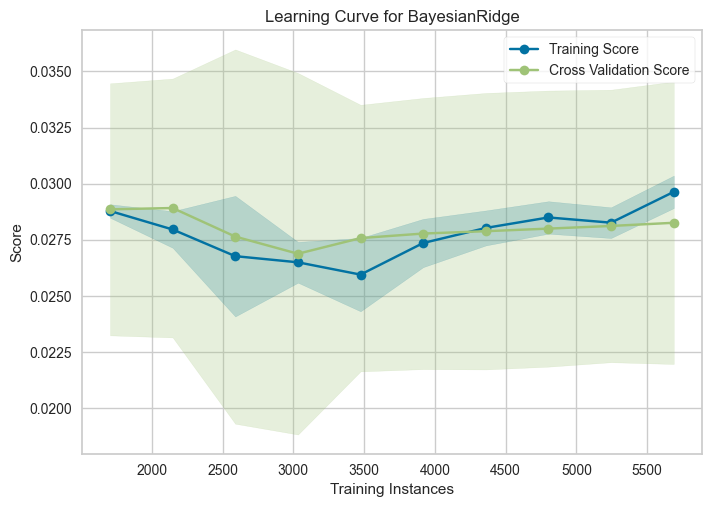

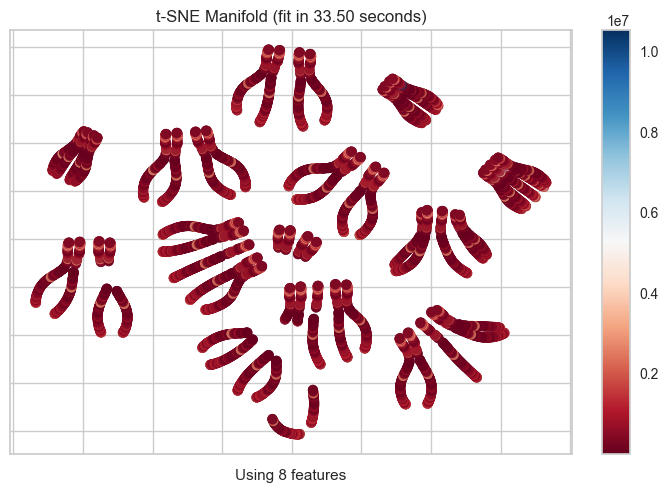

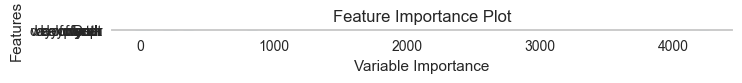

Parameters
alpha_1            1e-06
alpha_2            1e-06
alpha_init          None
compute_score      False
copy_X              True
fit_intercept       True
lambda_1           1e-06
lambda_2           1e-06
lambda_init         None
n_iter               300
tol                0.001
verbose            False


 
 >>plotting is  DONE! 
 

Pipeline(memory=Memory(location=None),
         steps=[('placeholder', None), ('actual_estimator', BayesianRidge())])

 
 >>print(final_mdl) for Model:br IS  DONE! 
 




 
 >>predict_model(final_mdl) for Model:br IS  DONE! 
 




 
 >>pred_mdl = predict_model(final_mdl, data=test) for Model:br IS  DONE! 
 


 
 >> Prediction of Model:br  IS  DONE!



 
 >>mdll = create_model(mdl) for Model:ridge IS  DONE! 
 



Fitting 10 folds for each of 10 candidates, totalling 100 fits

 
 >>tuned_mdl = tune_model(mdll) for Model:ridge IS  DONE! 
 




 
 >>predict_model(tuned_mdl) for Model:ridge IS  DONE! 
 


 
 >>final_mdl = finalize_model(tuned_mdl) for Model:ridge IS  DONE! 
 



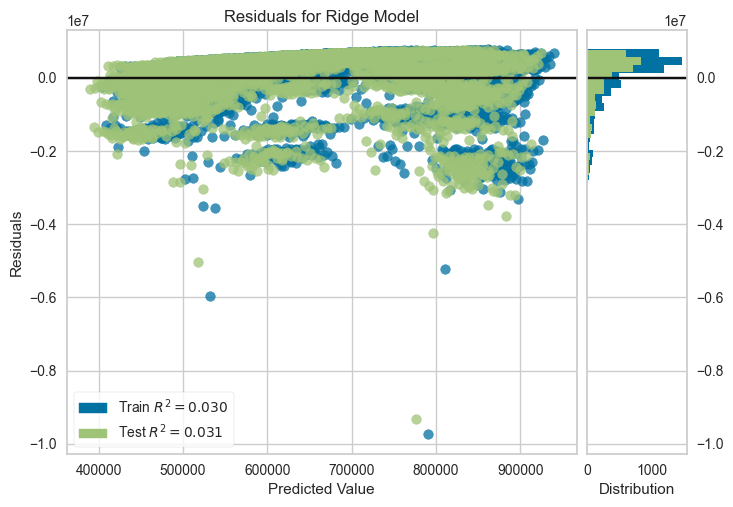

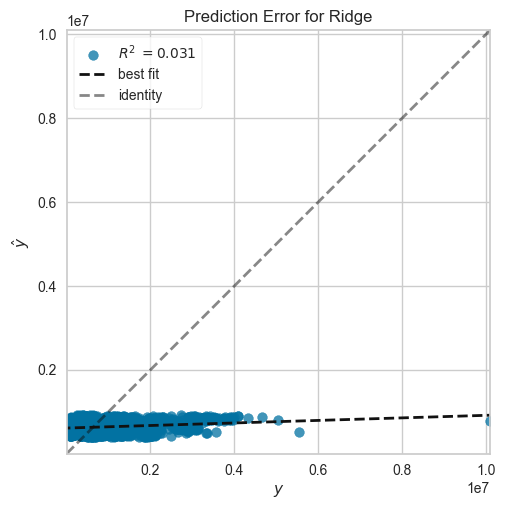

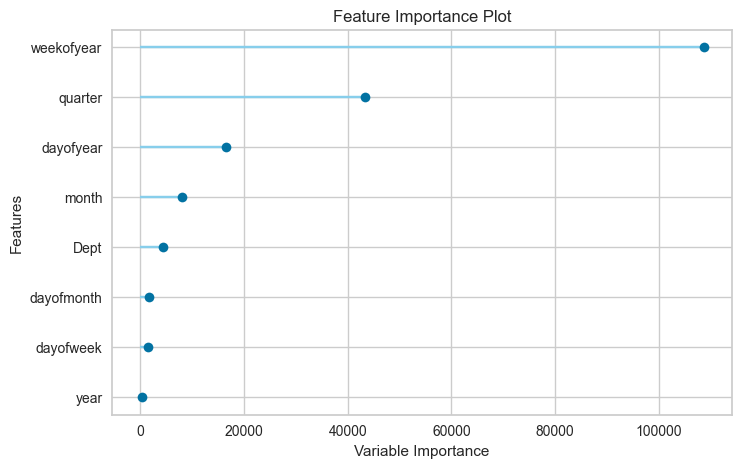

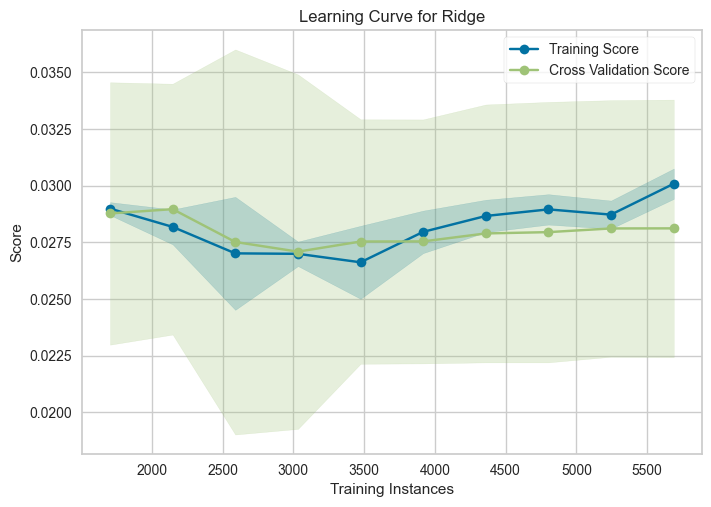

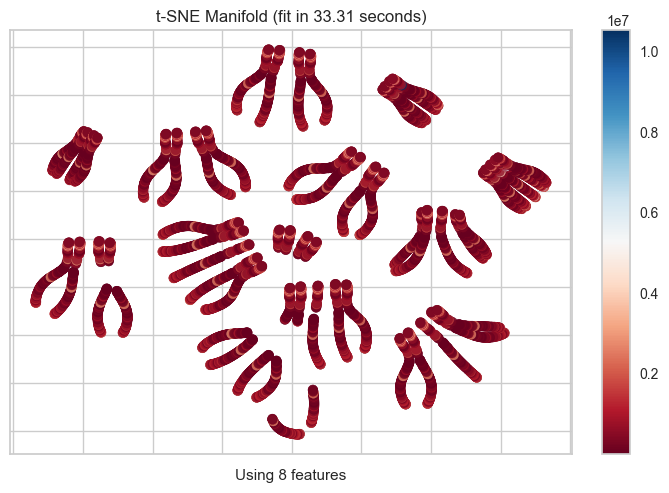

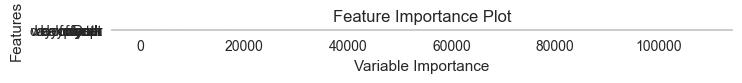

Parameters
alpha               9.85
copy_X              True
fit_intercept      False
max_iter            None
positive           False
random_state        8680
solver              auto
tol               0.0001


 
 >>plotting is  DONE! 
 

Pipeline(memory=Memory(location=None),
         steps=[('placeholder', None),
                ('actual_estimator',
                 Ridge(alpha=9.85, fit_intercept=False, random_state=8680))])

 
 >>print(final_mdl) for Model:ridge IS  DONE! 
 




 
 >>predict_model(final_mdl) for Model:ridge IS  DONE! 
 




 
 >>pred_mdl = predict_model(final_mdl, data=test) for Model:ridge IS  DONE! 
 


 
 >> Prediction of Model:ridge  IS  DONE!



 
 >>mdll = create_model(mdl) for Model:lar IS  DONE! 
 



Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).

 
 >>tuned_mdl = tune_model(mdll) for Model:lar IS  DONE! 
 




 
 >>predict_model(tuned_mdl) for Model:lar IS  DONE! 
 


 
 >>final_mdl = finalize_model(tuned_mdl) for Model:lar IS  DONE! 
 



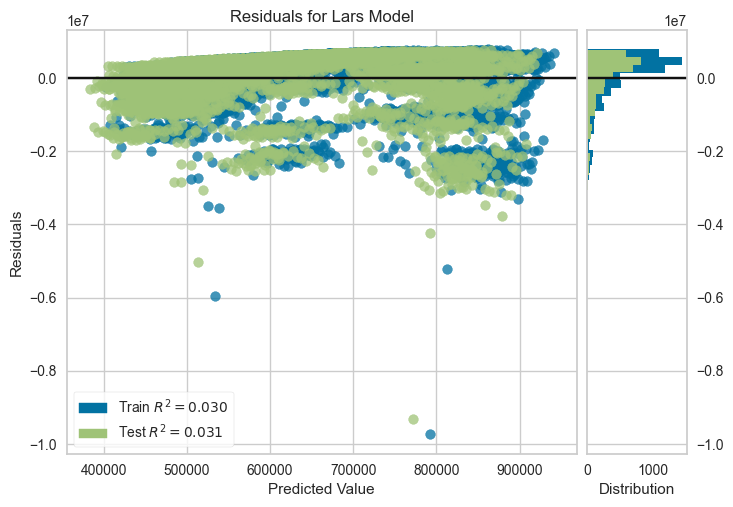

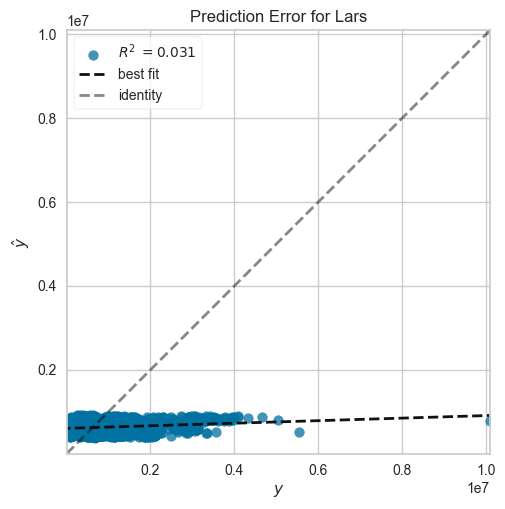

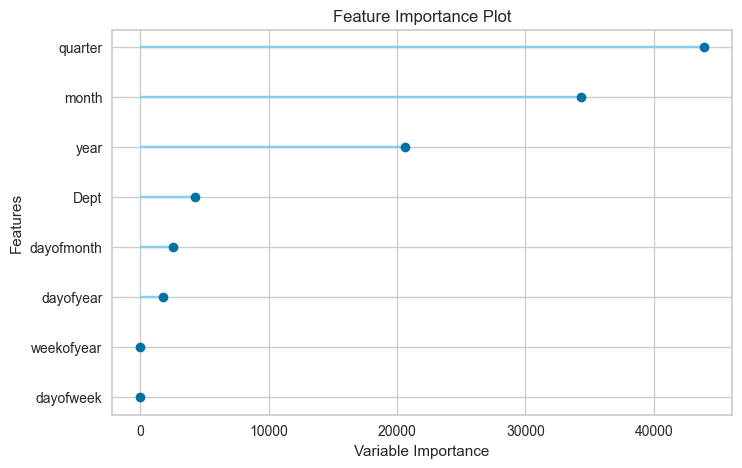

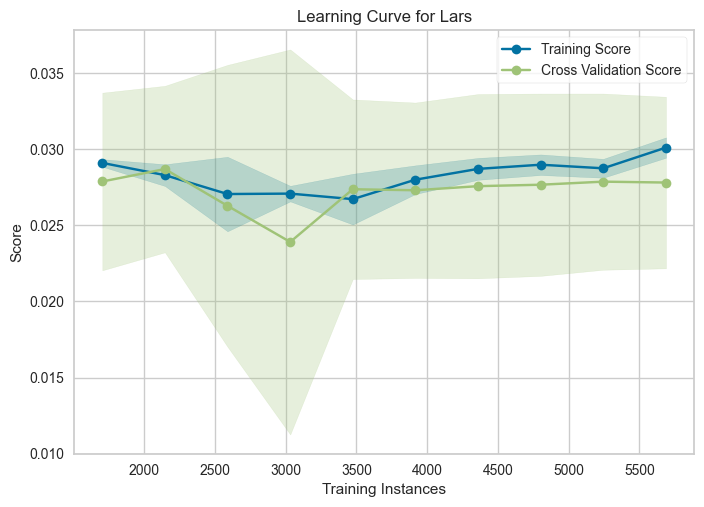

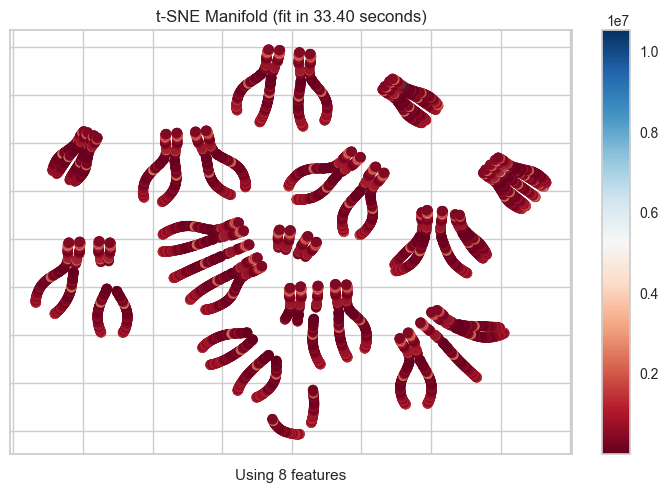

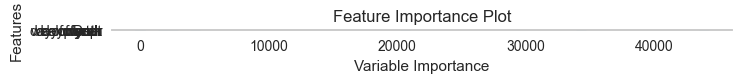

Parameters
copy_X                            True
eps              2.220446049250313e-16
fit_intercept                     True
fit_path                          True
jitter                            None
n_nonzero_coefs                    500
normalize                   deprecated
precompute                        auto
random_state                      8680
verbose                          False


 
 >>plotting is  DONE! 
 

Pipeline(memory=Memory(location=None),
         steps=[('placeholder', None),
                ('actual_estimator', Lars(random_state=8680))])

 
 >>print(final_mdl) for Model:lar IS  DONE! 
 




 
 >>predict_model(final_mdl) for Model:lar IS  DONE! 
 




 
 >>pred_mdl = predict_model(final_mdl, data=test) for Model:lar IS  DONE! 
 


 
 >> Prediction of Model:lar  IS  DONE!



 
 >>mdll = create_model(mdl) for Model:lr IS  DONE! 
 



Fitting 10 folds for each of 2 candidates, totalling 20 fits

 
 >>tuned_mdl = tune_model(mdll) for Model:lr IS  DONE! 
 




 
 >>predict_model(tuned_mdl) for Model:lr IS  DONE! 
 


 
 >>final_mdl = finalize_model(tuned_mdl) for Model:lr IS  DONE! 
 



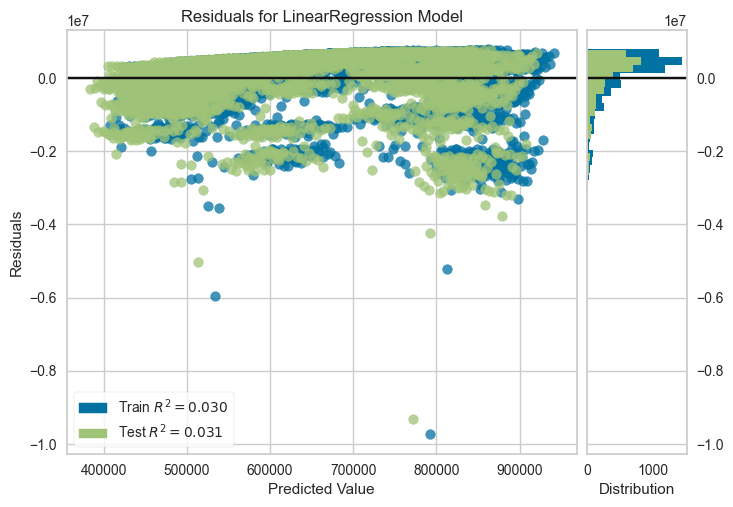

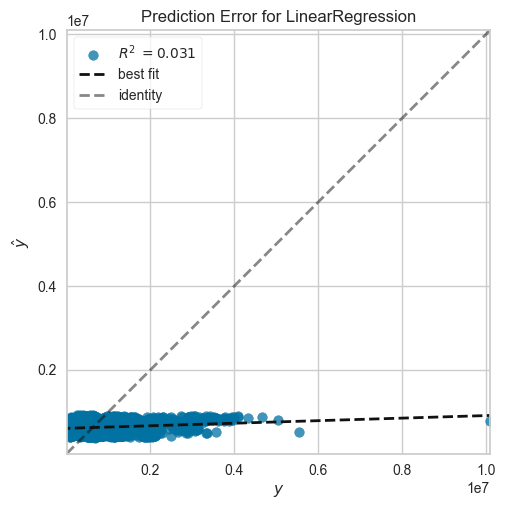

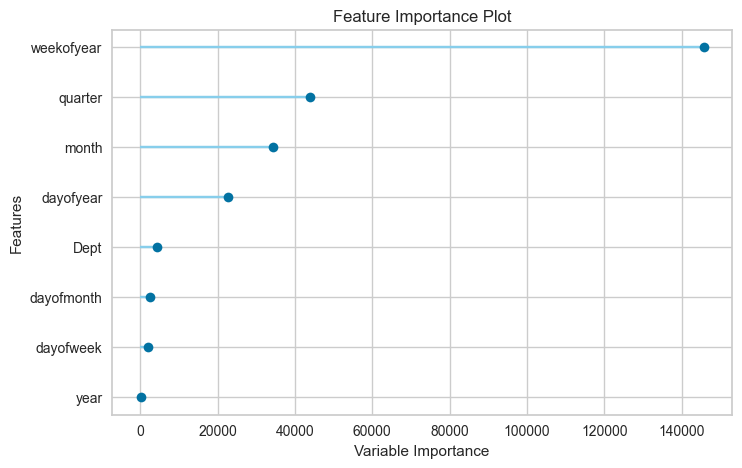

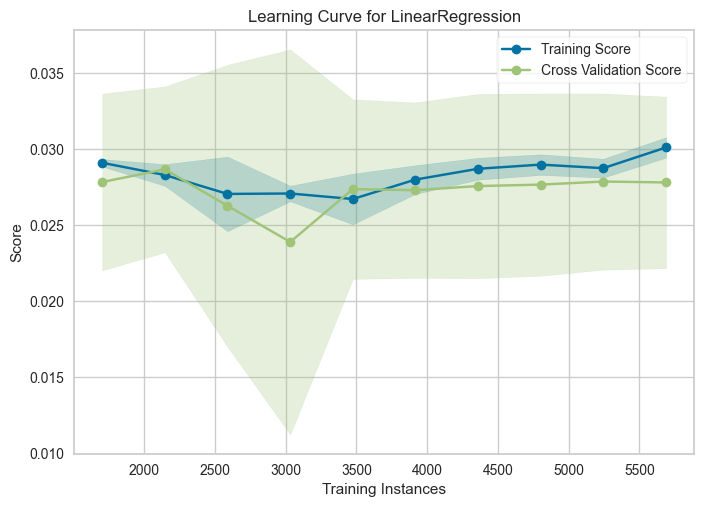

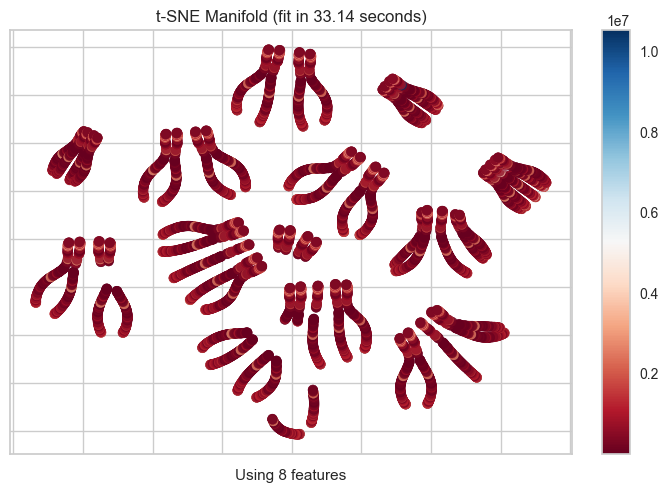

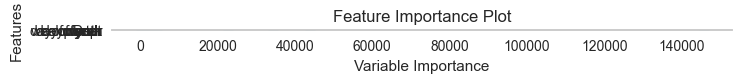

Parameters
copy_X              True
fit_intercept      False
n_jobs                -1
positive           False


 
 >>plotting is  DONE! 
 

Pipeline(memory=Memory(location=None),
         steps=[('placeholder', None),
                ('actual_estimator',
                 LinearRegression(fit_intercept=False, n_jobs=-1))])

 
 >>print(final_mdl) for Model:lr IS  DONE! 
 




 
 >>predict_model(final_mdl) for Model:lr IS  DONE! 
 




 
 >>pred_mdl = predict_model(final_mdl, data=test) for Model:lr IS  DONE! 
 


 
 >> Prediction of Model:lr  IS  DONE!



 
 >>mdll = create_model(mdl) for Model:dt IS  DONE! 
 



Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).

 
 >>tuned_mdl = tune_model(mdll) for Model:dt IS  DONE! 
 




 
 >>predict_model(tuned_mdl) for Model:dt IS  DONE! 
 


 
 >>final_mdl = finalize_model(tuned_mdl) for Model:dt IS  DONE! 
 



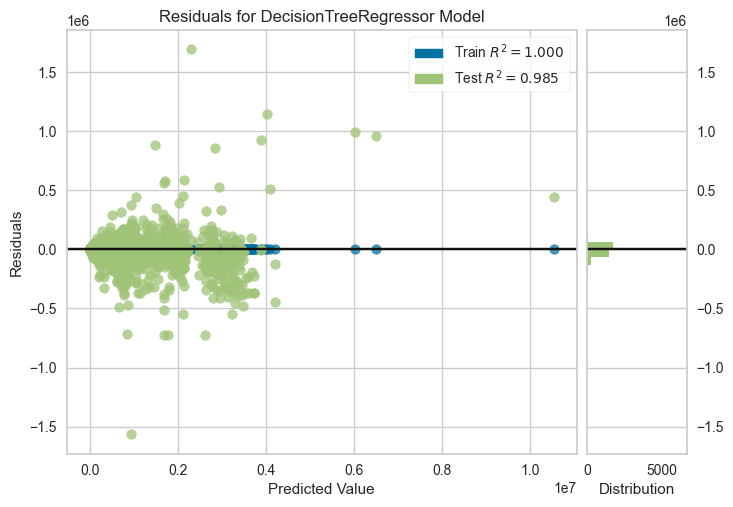

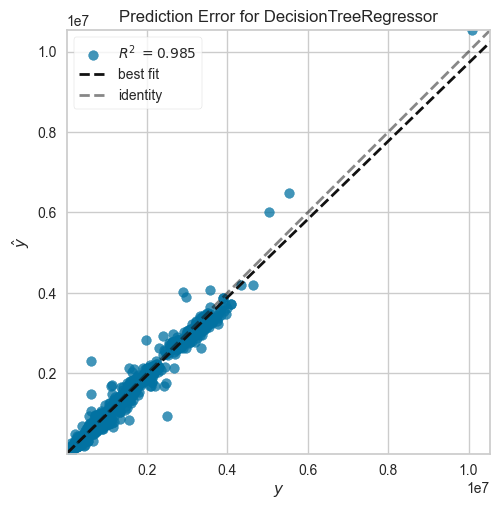

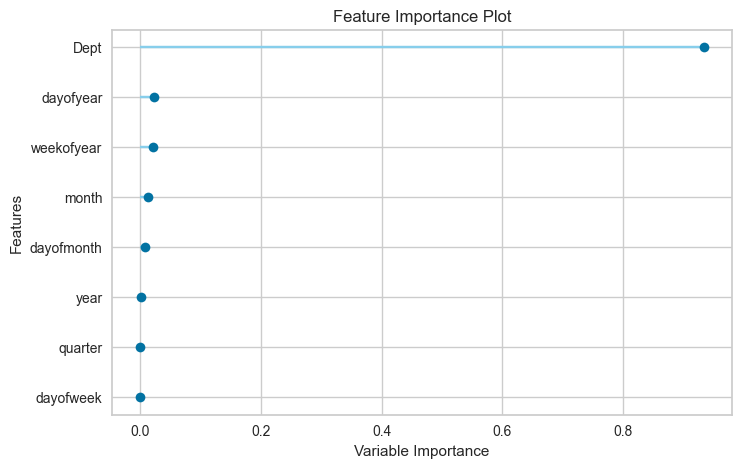

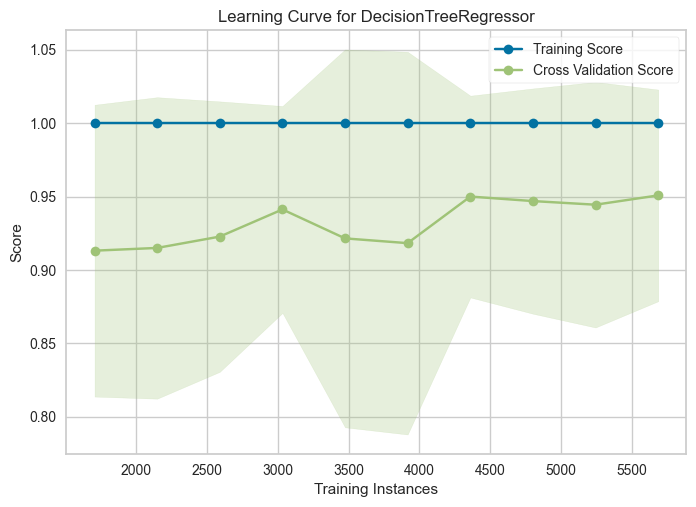

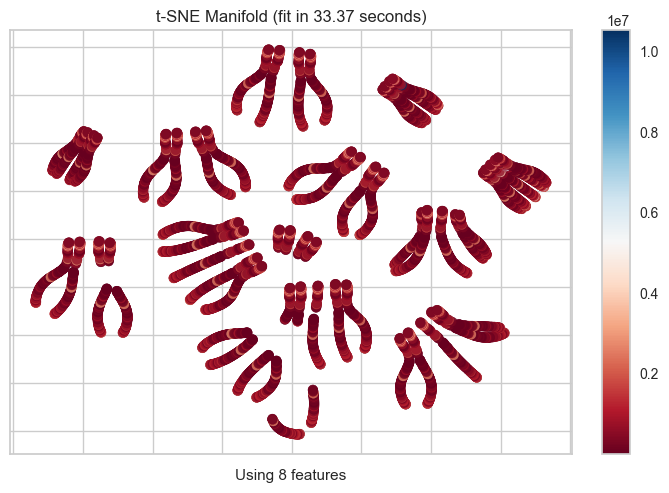

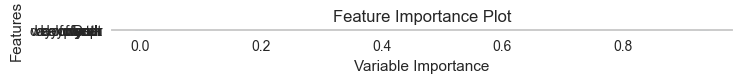

Parameters
ccp_alpha                           0.0
criterion                 squared_error
max_depth                          None
max_features                       None
max_leaf_nodes                     None
min_impurity_decrease               0.0
min_samples_leaf                      1
min_samples_split                     2
min_weight_fraction_leaf            0.0
random_state                       8680
splitter                           best


 
 >>plotting is  DONE! 
 

Pipeline(memory=Memory(location=None),
         steps=[('placeholder', None),
                ('actual_estimator', DecisionTreeRegressor(random_state=8680))])

 
 >>print(final_mdl) for Model:dt IS  DONE! 
 




 
 >>predict_model(final_mdl) for Model:dt IS  DONE! 
 




 
 >>pred_mdl = predict_model(final_mdl, data=test) for Model:dt IS  DONE! 
 


 
 >> Prediction of Model:dt  IS  DONE!



 
 >>mdll = create_model(mdl) for Model:rf IS  DONE! 
 



Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).

 
 >>tuned_mdl = tune_model(mdll) for Model:rf IS  DONE! 
 




 
 >>predict_model(tuned_mdl) for Model:rf IS  DONE! 
 


 
 >>final_mdl = finalize_model(tuned_mdl) for Model:rf IS  DONE! 
 



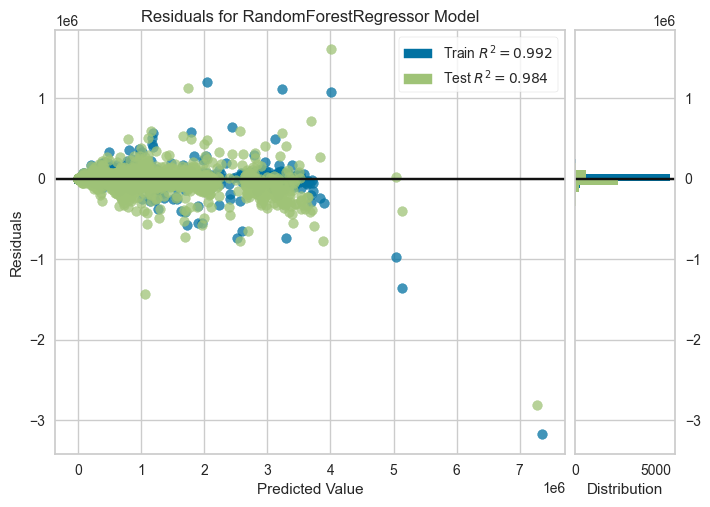

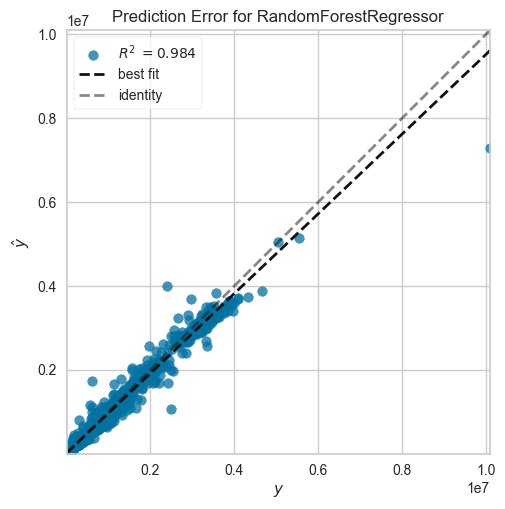

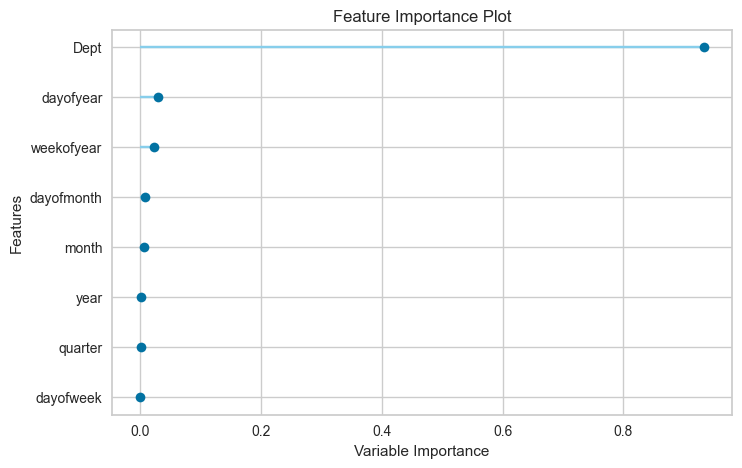

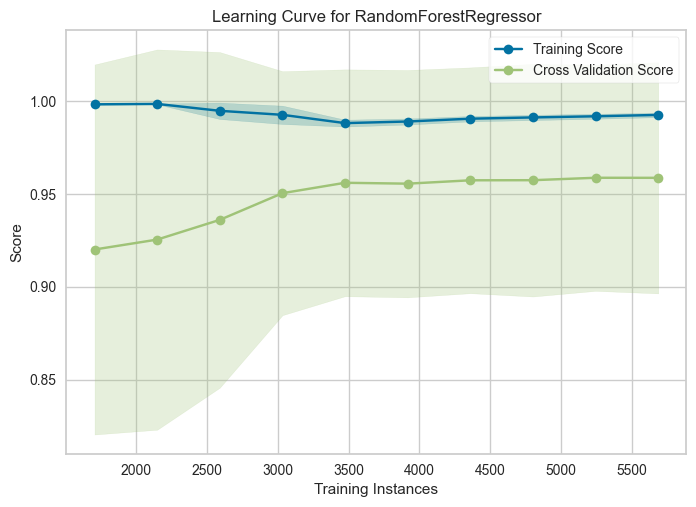

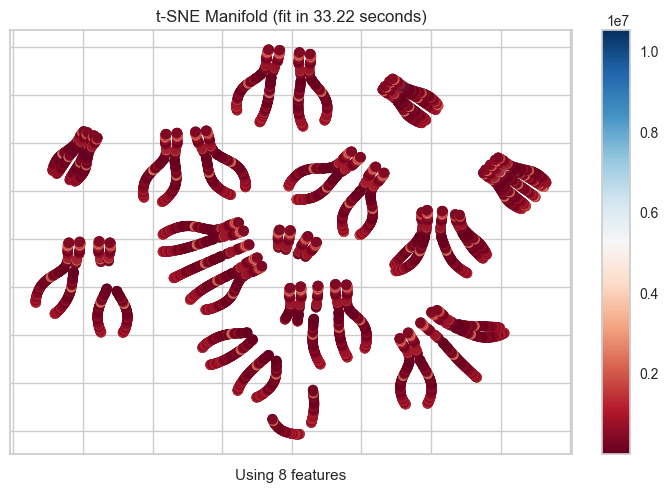

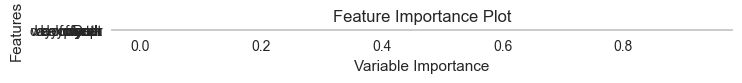

Parameters
bootstrap                          True
ccp_alpha                           0.0
criterion                 squared_error
max_depth                          None
max_features                        1.0
max_leaf_nodes                     None
max_samples                        None
min_impurity_decrease               0.0
min_samples_leaf                      1
min_samples_split                     2
min_weight_fraction_leaf            0.0
n_estimators                        100
n_jobs                               -1
oob_score                         False
random_state                       8680
verbose                               0
warm_start                        False


 
 >>plotting is  DONE! 
 

Pipeline(memory=Memory(location=None),
         steps=[('placeholder', None),
                ('actual_estimator',
                 RandomForestRegressor(n_jobs=-1, random_state=8680))])

 
 >>print(final_mdl) for Model:rf IS  DONE! 
 




 
 >>predict_model(final_mdl) for Model:rf IS  DONE! 
 




 
 >>pred_mdl = predict_model(final_mdl, data=test) for Model:rf IS  DONE! 
 


 
 >> Prediction of Model:rf  IS  DONE!



 
 >>mdll = create_model(mdl) for Model:et IS  DONE! 
 



Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).

 
 >>tuned_mdl = tune_model(mdll) for Model:et IS  DONE! 
 




 
 >>predict_model(tuned_mdl) for Model:et IS  DONE! 
 


 
 >>final_mdl = finalize_model(tuned_mdl) for Model:et IS  DONE! 
 



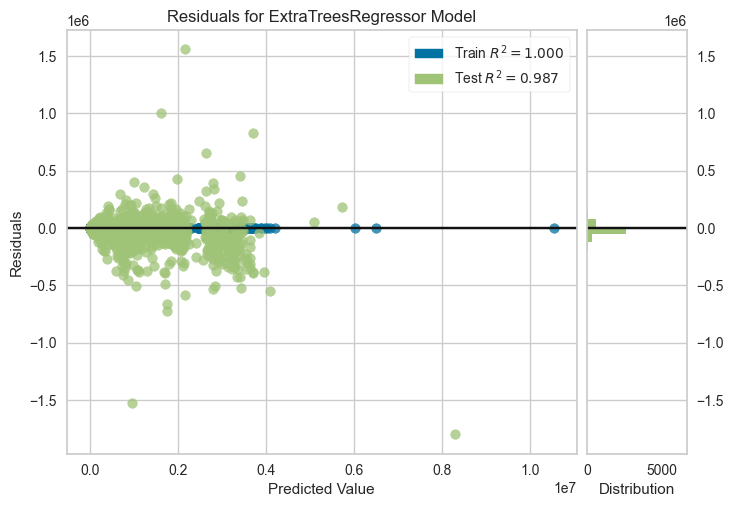

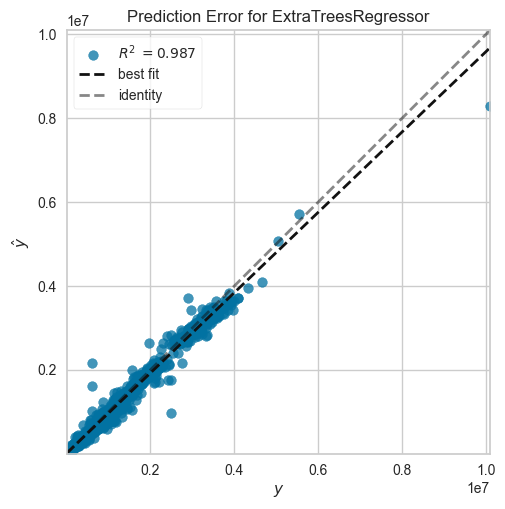

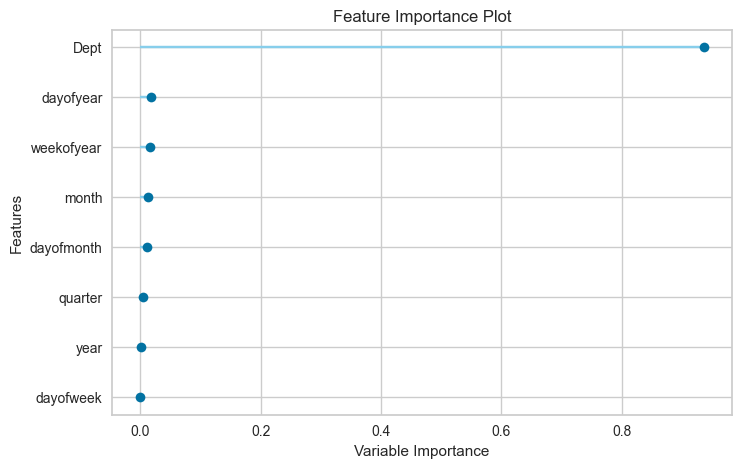

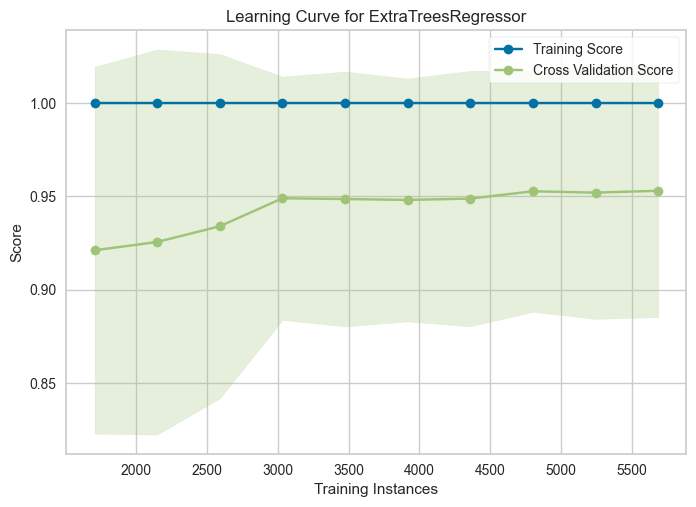

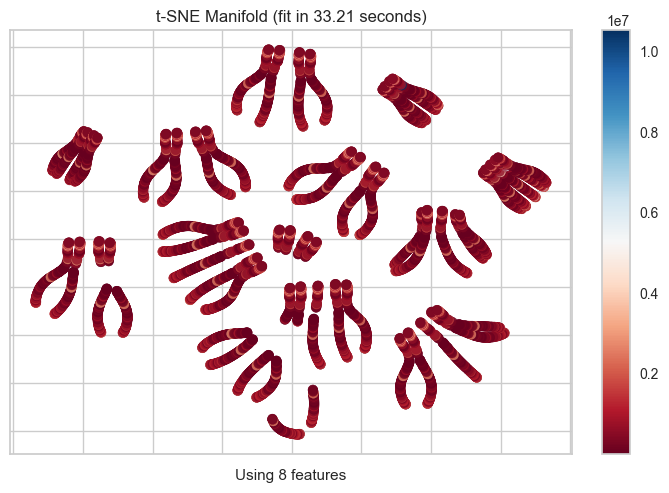

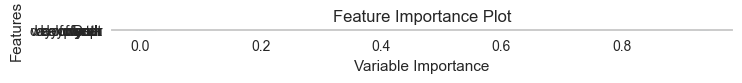

Parameters
bootstrap                         False
ccp_alpha                           0.0
criterion                 squared_error
max_depth                          None
max_features                        1.0
max_leaf_nodes                     None
max_samples                        None
min_impurity_decrease               0.0
min_samples_leaf                      1
min_samples_split                     2
min_weight_fraction_leaf            0.0
n_estimators                        100
n_jobs                               -1
oob_score                         False
random_state                       8680
verbose                               0
warm_start                        False


 
 >>plotting is  DONE! 
 

Pipeline(memory=Memory(location=None),
         steps=[('placeholder', None),
                ('actual_estimator',
                 ExtraTreesRegressor(n_jobs=-1, random_state=8680))])

 
 >>print(final_mdl) for Model:et IS  DONE! 
 




 
 >>predict_model(final_mdl) for Model:et IS  DONE! 
 




 
 >>pred_mdl = predict_model(final_mdl, data=test) for Model:et IS  DONE! 
 


 
 >> Prediction of Model:et  IS  DONE!

 >create_models func is Done! 

>>>>>>>>>>> Experience 52 is DONE! <<<<<<<<<<<<


In [9]:
# 6-Setting parameters and executing the experiment
mdls = ['xgboost', 'catboost', 'tr', 'lightgbm', 'gbr', 'huber', 'ada', 'par', 'omp', 'en', 'lasso', 'llar', 'br', 'ridge', 'lar', 'lr','dt', 'rf', 'et']
# excluded: 'dummy', 'knn', 'ransac', 'tr', 'kr', 'svm'

experiment52(dataset_sub3, '2011-10-19', mdls)